In [ ]:
""" VERSION 10 - ALL RANDOM FOREST MODELLING COMPLETED & AUTHOR 1-2 WORK TOGETHER PREDICTIONS OUTPUT FOR STAKEHOLDERS 
- 20-MAY-2021 Carol Paipa/Geoff Watkins

- VERSION 09 - TRAIN/TEST DATA & RANDOM FOREST MODELLING COMPLETED
- VERSION 08 - STREAMLINED CODE FOR DATA MODELLING ONLY UPDATED - 18-MAY-2021
- VERSION 07 - INITIAL COMBINED GRAPH & TOPIC MODELLING CODE - 16-MAY-2021
- VERSION 06 - GENERATE N-HOPS (max 5) STRIP OUT UNNECESSARY CELLS
- VERSION 05 - GENERATE N-HOPS (max 3) PLUS TIDY UP OF CODE - 6-MAY-2021
- VERSION 04 - CREATING WEIGHT FEATURES FOR DATA MODEL - 3-MAY-2021 
- VERSION 03 - GROUPING AUTHOR-1, AUTHOR-2 PAIRINGS, AND WEIGHT (COUNT) HOW MANY TIMES COAUTHORED TOGETHER - 28-APR-2021
- VERSION 02 - ...
- VERSION 01 - CREATING NODES, EDGES, NETWORK GRAPH

----------------------------------------------------
SINA CO-AUTHOR NETWORK GRAPH ANALYSIS 
----------------------------------------------------

Code for generating Nodes/Edges list for Co-Authors from Dimensions Dataset

Source data: Dimensions Published Papers for Profession Zhang between 2011 and 2021

1. Load in Dimensions Data Set
2. Split out Co-Authors per Paper
   - Assign Author ID for unique Author by Name
3. Generate Node list of unique Authors
4. Generate Edges list for Co-Author pairs - all Co-Authors are linked to each other
   - links between Papers will be based on unique Author names
"""
""" NEW FEATURES FOR MODEL WE COULD CONSIDER:
- coauthorship period - recent (0-2 yrs), medium (2-5 yrs), decade-10 (5-10 yrs), decade-20 (10-20 yrs), decade-20-plus (over 20 yrs)
- group size - solo (1), pair (2), group-small (3-5), group-med (5-10), group-large (10-20), group-xlarge (20-100), group-giant (100+)
- topic (of the paper) - limit to finite list in the data
- paper frequency of an author - the more times an author appears linked to papers, the more likely they are to colaborate
"""

' NEW FEATURES FOR MODEL WE COULD CONSIDER:\n- coauthorship period - recent (0-2 yrs), medium (2-5 yrs), decade-10 (5-10 yrs), decade-20 (10-20 yrs), decade-20-plus (over 20 yrs)\n- group size - solo (1), pair (2), group-small (3-5), group-med (5-10), group-large (10-20), group-xlarge (20-100), group-giant (100+)\n- topic (of the paper) - limit to finite list in the data\n- paper frequency of an author - the more times an author appears linked to papers, the more likely they are to colaborate\n'

In [1]:
!pip install gensim
!pip install nltk

# may or may not need to run this
import sys
# sys.path.insert(0, "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages")

## 1. Import Python Libraries and API's

In [2]:
# Load pandas
# !pip install wordcloud
import pandas as pd
import numpy as np
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns            
%matplotlib inline 
sns.set(color_codes=True)
import timeit

# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.preprocessing import StandardScaler, Normalizer, normalize

# regular expression package for removing punctuation from text
import re

# which folders host all the python files
import sys

import pandas as pd
pd.options.mode.chained_assignment = None

# Load extra requirements
import scipy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

# SOURCE FILE FOR OUR MODELLING
doc_dv = 'SINA_Papers_Zhang.csv'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paipac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Load in the Research Papers data
### We are analysing Professor Zhang published papers and citations

In [3]:
#-----------------------------------------------------------------------------
# Load in the Citations data
#-----------------------------------------------------------------------------
data = pd.read_csv(doc_dv, skiprows=1, low_memory=False)
print(data.info())

# cleanup unwanted rows & columns
df_data = data.copy()

# exclude rows where ID not begin with 'pub.'
df_data = df_data[df_data['Publication ID'].str.contains('pub.') == True]

# remove most columns exception for 'Publication ID', 'Cited references'
n = len(df_data.columns)
# print('n-columns = ',n)
# print('n-rows    = ', len(df_data),'(after filtering)','\n')

# only keep meaningful columns - not "unamed"
df_data.drop(df_data.iloc[:, 15:n], inplace = True, axis = 1) 
# print(df_data.columns.tolist(),'\n')

# clean up rows where Times Cited is not a number
df_data_fix = df_data.copy()
df_data['len_cited'] = [len(str(x)) for x in df_data['Times cited']]
# print(df_data.head(3))

# print('len(df_data)',len(df_data))
df_data = df_data.dropna(subset=['Times cited'])
# print('len(df_data)',len(df_data))

df_data = df_data[df_data['len_cited']<=3]
# print(df_data)

# convert Times cited to number
df_data['Fix'] = [int(x) for x in df_data['Times cited']]
columns=['Times cited']
df_data.drop(columns,axis=1,inplace=True)

# rename fixed column, back to Times cited
df_data = df_data.rename(columns={'Fix':'Times cited'})
# print(df_data.info())                    

# Extract only the useful dimensions - this version has Abstract & title information
df_data = df_data[['Publication ID','Title','Abstract','Authors','Authors Affiliations - Name of Research organization','Times cited','Cited references','PubYear']].copy()
df_data.columns = ['Publication ID','Title','Abstract','Authors','Authors Affiliations','Times Cited','Cited references','Pub Year']
df_data.head(3)

csv_file = 'Dimensions-Publication-Title-Abstract.csv'
df_data.to_csv(csv_file)

#-----------------------------------------------------------------------------
# Extract out individual Authors, Affiliations, Cited references - from lists
#-----------------------------------------------------------------------------
# df_citat['Authors'][1]
# eg: 'Molin, Nicole L.; Molin, Clifford; Dalpatadu, Rohan J.; Singh, Ashok K.'

df_pub = df_data[['Publication ID','Authors','Authors Affiliations','Cited references','Times Cited','Pub Year']].copy()

# export only the columns used below - this version Abstract & title information are removed
df_pub.to_csv('Dimensions-Publication-Small.csv')

# Replace NaN with a ';' - will delete these later stage
df_pub['Authors_2'] = df_pub['Authors'].fillna(';')
df_pub['Authors Affiliations_2'] = df_pub['Authors Affiliations'].fillna(';')
df_pub['Cited references_2'] = df_pub['Cited references'].fillna(';')

# rename our fixed columns back to the original ones
df_pub = df_pub.drop(columns=(['Authors','Authors Affiliations','Cited references']))
df_pub.columns=(['Publication ID','Times Cited','Pub Year','Authors','Authors Affiliations','Cited references'])

# Remove junk author to avoid count/sorting fail
pub_list = ['pub.1134802587','pub.1134588066']
df_pub[~df_pub['Publication ID'].isin(pub_list)]

# some test publications during development
pub_list_in = ['pub.1129598070','pub.1129601032','pub.1135906085','pub.1136271880']

# Need to set Pub Year as int
df_pub['Pub Year'] = df_pub['Pub Year'].astype('int')

df_pub = df_pub.reset_index()
df_pub

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 15 columns):
 #   Column                                                   Non-Null Count  Dtype 
---  ------                                                   --------------  ----- 
 0   Publication ID                                           401 non-null    object
 1   DOI                                                      396 non-null    object
 2   Title                                                    401 non-null    object
 3   Abstract                                                 385 non-null    object
 4   Source title/Anthology title                             401 non-null    object
 5   PubYear                                                  401 non-null    int64 
 6   Volume                                                   267 non-null    object
 7   Issue                                                    161 non-null    object
 8   Pagination                              

,index,Publication ID,Times Cited,Pub Year,Authors,Authors Affiliations,Cited references
0,0,pub.1136414874,0,2021,"Xiong, Haobo; Wang, Shuting; Tang, Mingrong; W...",East China Normal University; Zhejiang Gongsha...,"[Bollacker, Kurt; Evans, Colin; Paritosh, Prav..."
1,1,pub.1137016159,0,2021,"Wang, Hanchen; Lian, Defu; Zhang, Ying; Qin, L...",University of Technology Sydney; University of...,"[Williams, Ronald J.]|[]|Machine Learning|1992..."
2,2,pub.1136783205,0,2021,"Yang, Zhengyi; Lai, Longbin; Lin, Xuemin; Hao,...",;,;
3,3,pub.1136537786,1,2021,"Wang, Kai; Lin, Xuemin; Qin, Lu; Zhang, Wenjie...",UNSW Sydney; University of Technology Sydney,"[Sim, Kelvin; Li, Jinyan; Gopalkrishnan, Vivek..."
4,4,pub.1135655976,0,2021,"Chen, Xiaoshuang; Lai, Longbin; Qin, Lu; Lin, ...",UNSW Sydney; Alibaba Group (China); University...,"[Fogaras, Dániel; Rácz, Balázs]|[ur.0760765624..."
...,...,...,...,...,...,...,...
396,396,pub.1016913078,0,1994,"Lin, Xuemin; Orlowska, Maria E.",University of Queensland,"[Kumar, Akhil; Segev, Arie]|[ur.014256761101.4..."
397,397,pub.1049668144,24,1993,"Lin, Xuemin; Orlowska, Maria; Zhang, Yanchun",University of Queensland,"[Apers, Peter M. G.]|[ur.014010434505.68]|ACM ..."
398,398,pub.1014107317,112,1993,"Eades, Peter; Lin, Xuemin; Smyth, W.F.",University of Newcastle Australia; University ...,"[Spencer, J.]|[]|Networks|1971|1|2|135-138|10...."
399,399,pub.1062960755,19,1993,"EADES, PETER; LIN, TAO; LIN, XUEMIN",University of Newcastle Australia,;


## 2.1 How many papers are within the last 10 years only
#### Reduce total papers for data modelling within last 10 years, pub year >= 2016

In [4]:
""" SPLIT X-TRAIN AND Y-TEST DATA FOR MODELLING NOW ----------------"""
""" TRAINING DATA IS YEARS 2011 - 2017                              """
""" TARGET (Y) DATA IS YEARS 2019 - 2021                            """

pub_year_X = 2011  # start of training data, ie: 2009 to 2018
pub_year_y = 2019  # start of testing data, ie: 2019 to 2021

df_pub_X = df_pub[(df_pub['Pub Year'] >= pub_year_X) & (df_pub['Pub Year'] < pub_year_y)].copy()
df_pub_y = df_pub[df_pub['Pub Year'] >= pub_year_y].copy()

""" MAY INCREASE THIS FUTURE RUNS - WHEN WE HAVE FINAL WORKING MODEL """

# max_coauthor = 10 - replaced by author-total-papers they are linked to, ie: connectedness
min_pub_year = 2011
auth_total_papers=1
auth_total_papers_max=500

print('Total papers     =',len(df_pub))
print(f'Papers pre-{pub_year_X}  =',len(df_pub[df_pub['Pub Year']<pub_year_X]),'\t{:.0f}%'.format(len(df_pub[df_pub['Pub Year']<pub_year_X])/len(df_pub)*100))
print(f'Papers {pub_year_X}-{pub_year_y-1} =',len(df_pub_X),'\t{:.0f}%'.format(len(df_pub_X)/len(df_pub)*100))
print(f'Papers {pub_year_y}-2021 =',len(df_pub_y),'\t{:.0f}%'.format(len(df_pub_y)/len(df_pub)*100))

# reduce total papers down to only ones within last 10 years
df_pub = df_pub[df_pub['Pub Year'] >= min_pub_year]

Total papers     = 401
Papers pre-2011  = 121 	30%
Papers 2011-2018 = 197 	49%
Papers 2019-2021 = 83 	21%


## 3. Create wide-column table with each individual author per column 
#### Each Paper pub.ID is one row, each column to the right of "# Authors" is one author

In [5]:
#----------------------------------------------------
# Extract individual strings from list - Authors
#----------------------------------------------------
def extract_author_list(df_pub, col_index = 6):
    df_pub['Authors_Split'] = [list(x.split('; ')) for x in df_pub['Authors']]
    #print(f'len(df_pub) {len(df_pub)}')  #, df_pub.head()\n',df_pub.head())
    
    # df_test['Authors_Split'].iloc[2]
    df_split = df_pub[['index','Publication ID','Times Cited','Pub Year','Authors_Split']].copy()
    df_split

    # how many co-authors for each paper
    df_split['# Authors'] = [len(x) for x in df_split['Authors_Split']]
    df_split.sort_values('# Authors', ascending=False)
    df_split

    # Dataframe just of Pub-ID with Index 0-N rows NOTE: if adding new columns before # Authors - add +1 (per new column) to col_index
    # col_index = 6
    df_paper = pd.DataFrame(df_split.iloc[:,:col_index])   #.values.tolist())  #.reset_index()
    # temp name for index column
    df_paper['index_pub'] = df_paper['index']
    df_paper = df_paper[['index','index_pub','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors']]
    df_paper
    #print('\ndf_paper\n', df_paper)

    # Dataframe just of Authors but converted to columns (across)
    df_auth = df_split[['index','Authors_Split']].copy()
    df_auth_cols = df_auth.iloc[:,1].apply(pd.Series).reset_index()  
    df_auth_cols
    #print('\ndf_auth_cols\n', df_auth_cols)

    # Concat (join) dataframes based on Index (hopefully they match original Pub-ID and Author rows)
    df_new = []
    df_new = pd.merge(df_paper, df_auth_cols)
    df_new = df_new.fillna('')

    # remove both index columns
    df_new.drop(df_new.iloc[:,:1], inplace = True, axis = 1)
    df_new = df_new.rename(columns={'index_pub':'index'})

    # 280 rows × 19 columns - papers from 2011
    # 172 rows × 19 columns - papers from 2016
    return df_new


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_X_new = extract_author_list(df_pub_X) 
df_pub_y_new = extract_author_list(df_pub_y)

print(f'Unique papers X_new {pub_year_X}-{pub_year_y-1} =',len(df_pub_X_new['Publication ID'].unique()))
print(f'Unique papers y_new {pub_year_y}-{pub_year_y+2} =',len(df_pub_y_new['Publication ID'].unique()))
df_pub_X_new

Unique papers X_new 2011-2018 = 197
Unique papers y_new 2019-2021 = 83


,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,0,1,2,3,4,5,6,7
0,83,pub.1110506917,2,2018,"[Wang, Xubo, Qin, Lu, Lin, Xuemin, Zhang, Ying...",5,"Wang, Xubo","Qin, Lu","Lin, Xuemin","Zhang, Ying","Chang, Lijun",,,
1,84,pub.1110419433,0,2018,"[Lin, Xuemin]",1,"Lin, Xuemin",,,,,,,
2,85,pub.1111651043,1,2018,"[Zhang, Junjie, Wang, Liping, Zhang, Wenjie, Y...",4,"Zhang, Junjie","Wang, Liping","Zhang, Wenjie","Yao, Junjie",,,,
3,86,pub.1109824256,6,2018,"[Zhang, Fan, Li, Conggai, Zhang, Ying, Qin, Lu...",5,"Zhang, Fan","Li, Conggai","Zhang, Ying","Qin, Lu","Zhang, Wenjie",,,
4,87,pub.1107774855,5,2018,"[Zhu, Weijie, Chen, Chen, Wang, Xiaoyang, Lin,...",4,"Zhu, Weijie","Chen, Chen","Wang, Xiaoyang","Lin, Xuemin",,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,275,pub.1050177341,8,2011,"[Zhu, Ke, Zhang, Wenjie, Zhu, Gaoping, Zhang, ...",5,"Zhu, Ke","Zhang, Wenjie","Zhu, Gaoping","Zhang, Ying","Lin, Xuemin",,,
193,276,pub.1036735375,4,2011,"[Peng, Peng, Zou, Lei, Chen, Lei, Lin, Xuemin,...",5,"Peng, Peng","Zou, Lei","Chen, Lei","Lin, Xuemin","Zhao, Dongyan",,,
194,277,pub.1020323706,60,2011,"[Qin, Jianbin, Wang, Wei, Lu, Yifei, Xiao, Chu...",5,"Qin, Jianbin","Wang, Wei","Lu, Yifei","Xiao, Chuan","Lin, Xuemin",,,
195,278,pub.1016344151,12,2011,"[Zhu, Yuanyuan, Qin, Lu, Yu, Jeffrey Xu, Ke, Y...",5,"Zhu, Yuanyuan","Qin, Lu","Yu, Jeffrey Xu","Ke, Yiping","Lin, Xuemin",,,


## 4. Create long-row table now with each Paper + Author as one row
#### - one row is paper pub.id + one author
#### - papers with multiple co-authors will appear multiple (row) times
eg: paper pub.1109780440 has 1212 authors => so will results in 1212 rows

In [6]:
#------------------------------------------------------
# iterate across all author columns, append them after each other, final concat for all appended dataframes
#------------------------------------------------------
# create Pub-ID column name so can link back to original data
def create_paper_coauthor(df_new, col_list, col_index=6):
    # print('\nauthors col_list (',col_list[col_index-1],') len =',col_list[len(col_list)-1])
    col_end = col_list[len(col_list)-1]

    # iterate across all author columns
    all_auth = []
    new_list = ['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors','Author']
    for col in col_list[col_index:]:
        df_app = []
        df_app = df_new[['index','Publication ID','Times Cited','Pub Year','Authors_Split','# Authors',col]].copy()
        df_app.columns = new_list
        all_auth.append(df_app)

    # concatenated all appended Author (wide) columns into 1 single column
    df_pub_auth = pd.concat(all_auth)
    print('pub-auth all rows         ',df_pub_auth.shape)

    # remove rows with blank Authors
    df_pub_auth = df_pub_auth[df_pub_auth['Author']!='']  
    df_pub_auth = df_pub_auth[df_pub_auth['Author']!=';']  
    print('pub-auth del blank Authors',df_pub_auth.shape,'\n')

    # Total Authors for all papers - before any filtering on number of co-authors
    # authors col_list =  # Authors - 1211
    # len pub-auth all rows          (1645896, 7)
    # len pub-auth del blank Authors (30836, 7)

    # save output Published Papers - each Author linked to paper
    # skip this step for production - creates 209Mb file we are not really using
    # df_pub_auth.to_csv('Dimensions-Published-Authors.csv')

    """ Polution papers >= 2011 pub year
    authors col_list =  # Authors - 1211
    len pub-auth all rows          (1645896, 7)
    len pub-auth del blank Authors (30836, 7)
    """

    """ Prof Zhang papers >= 2011 pub year
    authors col_list =  # Authors - 12
    len pub-auth all rows          (3640, 7)
    len pub-auth del blank Authors (1379, 7)
    """
    return df_pub_auth

#---------------------------------------------------------
col_list = list(df_pub_X_new.columns.values)
col_list

# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_auth_X = create_paper_coauthor(df_pub_X_new, col_list)
df_pub_auth_y = create_paper_coauthor(df_pub_y_new, col_list)

print(f'Unique paper-year-author X {pub_year_X}-{pub_year_y-1} =',len(df_pub_auth_X))
print(f'Unique paper-year-author y {pub_year_y}-{pub_year_y+2} =',len(df_pub_auth_y))
df_pub_auth_X

pub-auth all rows          (1576, 7)
pub-auth del blank Authors (908, 7) 

pub-auth all rows          (664, 7)
pub-auth del blank Authors (460, 7) 

Unique paper-year-author X 2011-2018 = 908
Unique paper-year-author y 2019-2021 = 460


,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author
0,83,pub.1110506917,2,2018,"[Wang, Xubo, Qin, Lu, Lin, Xuemin, Zhang, Ying...",5,"Wang, Xubo"
1,84,pub.1110419433,0,2018,"[Lin, Xuemin]",1,"Lin, Xuemin"
2,85,pub.1111651043,1,2018,"[Zhang, Junjie, Wang, Liping, Zhang, Wenjie, Y...",4,"Zhang, Junjie"
3,86,pub.1109824256,6,2018,"[Zhang, Fan, Li, Conggai, Zhang, Ying, Qin, Lu...",5,"Zhang, Fan"
4,87,pub.1107774855,5,2018,"[Zhu, Weijie, Chen, Chen, Wang, Xiaoyang, Lin,...",4,"Zhu, Weijie"
...,...,...,...,...,...,...,...
37,120,pub.1091840060,0,2017,"[Jiang, Shanqing, Zhang, Chengyuan, Zhang, Yin...",7,"Wang, Xiaoyang"
134,217,pub.1095297482,0,2013,"[Chen, Jinjun, Nepal, Surya, Cafaro, Massimo, ...",8,"Chen, Jinjun"
137,220,pub.1048810164,2,2013,"[Liu, Qing, Zhao, Xiang, Taylor, Kerry, Lin, X...",7,"Miller, Richard"
158,241,pub.1014620872,2,2013,"[Liu, Qing, Taylor, Kerry, Zhao, Xiang, Squire...",7,"Miller, Richard"


### 5. CREATE "Author" nodes - assume Author with same name is the same Author - may not be true in real life

#### - node_id will be unique per author name, and becomes the author-index later on
#### - size_author is the number of papers that authors name can be linked to
#### Some authors have full names, or lastname + initial - but for now, we will treat them as 2 authors


In [7]:
#-----------------------------------------------------------
# create Author nodes - assume Author with same name
# is the same Author - may not be true in real life
#-----------------------------------------------------------

def create_author_nodes(df_pub_auth):
    df_node_author = df_pub_auth.copy()
    df_node_author = df_node_author[['index','Author']].groupby('Author').count().reset_index().reset_index()
    df_node_author.columns=(['index_author','Author','Author Total Papers'])
    df_node_author

    # combine Published-Author + Author-ID to link Paper-ID and Author-ID
    df_pub_auth_count = df_pub_auth.join(df_node_author.set_index('Author'), on='Author')
    df_pub_auth_count

    #auth_idx = [4473,5147]
    #auth_check = df_pub_auth_count[df_pub_auth_count['index_author'].isin(auth_idx)]
    #auth_check.sort_values('Publication ID')

    # save this data to csv - for reloading further down if code crashes with big max_coauthor (eg: 100)
    df_pub_auth_count.to_csv('df_pub_auth_count.csv', index=0)

    #-------------------------------------------------------
    # finish creating nodes for each Author (unique by name)
    df_node_author['node_group']='author'
    df_node_author.columns=(['node_id','node_name','size_author','node_group'])
    df_node_author.to_csv('df_node_author.csv', index=0)
    df_node_author

    return df_pub_auth_count, df_node_author

   
#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_auth_count_X, df_node_author_X = create_author_nodes(df_pub_auth_X)
df_pub_auth_count_y, df_node_author_y = create_author_nodes(df_pub_auth_y)

#-------------------------------------------------------
# check rows are the same - start of Pub list, end of Author list - matching above lists
nodes_X = df_node_author_X[['node_id','node_name','node_group','size_author']]
nodes_y = df_node_author_y[['node_id','node_name','node_group','size_author']]

sample_author = nodes_X['node_id'].unique().tolist() + nodes_y['node_id'].unique().tolist()
sample_author = pd.DataFrame(sample_author)[0].unique().tolist()
print('Unique authors =',len(sample_author))
    
print(f'Number of individual authors X = {len(nodes_X)} - before any filtering')
print(f'Number of individual authors y = {len(nodes_y)} - before any filtering')

print('Nodes_X')
nodes_X.sort_values('size_author', ascending=False).head(10)

Unique authors = 171
Number of individual authors X = 171 - before any filtering
Number of individual authors y = 133 - before any filtering
Nodes_X


,node_id,node_name,node_group,size_author
58,58,"Lin, Xuemin",author,174
147,147,"Zhang, Wenjie",author,106
150,150,"Zhang, Ying",author,83
81,81,"Qin, Lu",author,42
5,5,"Chang, Lijun",author,35
7,7,"Cheema, Muhammad Aamir",author,25
109,109,"Wang, Wei",author,20
133,133,"Yu, Jeffrey Xu",author,19
116,116,"Wang, Yang",author,15
136,136,"Yuan, Long",author,14


## 6. Create Co-Author Relationships for Network Graph
#### Each Co-Author of a Paper is linked to each other - like a Clique (sub-network)
#### Authors that are linked to more papers, will have more connectedness
#### And should return more n_hops in the network, thus a better quality network for modelling

In [8]:
#---------------------------------------------------------------
# LIMIT PAPERS CO-AUTHOR SIZE - JUST DURING DEVELOPMENT
# Number of papers with max 5 authors: 3541  
# max 10 = 10624 rows, max 100 = 18640 rows - when all pub years
# max 100 = 12424 rows when pub year >= 2011
#---------------------------------------------------------------

# df_pub_auth_subset = df_pub_auth_count[df_pub_auth_count['# Authors']<=max_coauthor].copy()
# print(f'\nNumber of papers with max {max_coauthor} authors:',len(df_pub_auth_subset),'\n')

def creat_pub_auth_subset(df_pub_auth_count, nodes, auth_total_papers=3, auth_total_papers_max=500):
    df_pub_auth_subset = df_pub_auth_count[(df_pub_auth_count['Author Total Papers']>=auth_total_papers) & (df_pub_auth_count['Author Total Papers']<auth_total_papers_max)].copy()

    print(f"Total authors before filtering =",len(nodes),f"\nAuthors linked to ({auth_total_papers}) or more, and less than ({auth_total_papers_max}) papers =",len(df_pub_auth_subset['Publication ID'].unique()))
    print('\nmin_pub_year          =',min_pub_year)
    print('auth_total_papers     =',auth_total_papers)
    print('auth_total_papers_max =',auth_total_papers_max)
    print('papers in data        =',len(df_pub_auth_subset['Publication ID'].unique()))
    print('authors in data       =',len(df_pub_auth_subset['index_author'].unique()),'\n')

    print('Authors in data', sorted(df_pub_auth_subset['index_author'].unique()))

    # data for Published Paper ID linked to Co-Author ID's
    # 10353 rows × 9 columns where auth-papers-count >=10 and < 100
    # 5089 rows × 9 columns where auth-papers-count >=20 and < 100
    
    return df_pub_auth_subset


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_auth_subset_X = creat_pub_auth_subset(df_pub_auth_count_X, nodes_X, auth_total_papers, auth_total_papers_max)
df_pub_auth_subset_y = creat_pub_auth_subset(df_pub_auth_count_y, nodes_y, auth_total_papers, auth_total_papers_max)

df_pub_auth_subset_X

Total authors before filtering = 171 
Authors linked to (1) or more, and less than (500) papers = 197

min_pub_year          = 2011
auth_total_papers     = 1
auth_total_papers_max = 500
papers in data        = 197
authors in data       = 171 

Authors in data [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,

,index,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Total Papers
0,83,pub.1110506917,2,2018,"[Wang, Xubo, Qin, Lu, Lin, Xuemin, Zhang, Ying...",5,"Wang, Xubo",114,2
1,84,pub.1110419433,0,2018,"[Lin, Xuemin]",1,"Lin, Xuemin",58,174
2,85,pub.1111651043,1,2018,"[Zhang, Junjie, Wang, Liping, Zhang, Wenjie, Y...",4,"Zhang, Junjie",144,1
3,86,pub.1109824256,6,2018,"[Zhang, Fan, Li, Conggai, Zhang, Ying, Qin, Lu...",5,"Zhang, Fan",143,8
4,87,pub.1107774855,5,2018,"[Zhu, Weijie, Chen, Chen, Wang, Xiaoyang, Lin,...",4,"Zhu, Weijie",167,1
...,...,...,...,...,...,...,...,...,...
37,120,pub.1091840060,0,2017,"[Jiang, Shanqing, Zhang, Chengyuan, Zhang, Yin...",7,"Wang, Xiaoyang",113,13
134,217,pub.1095297482,0,2013,"[Chen, Jinjun, Nepal, Surya, Cafaro, Massimo, ...",8,"Chen, Jinjun",11,2
137,220,pub.1048810164,2,2013,"[Liu, Qing, Zhao, Xiang, Taylor, Kerry, Lin, X...",7,"Miller, Richard",72,2
158,241,pub.1014620872,2,2013,"[Liu, Qing, Taylor, Kerry, Zhao, Xiang, Squire...",7,"Miller, Richard",72,2


## 7. CREATE AUTHOR-PAIRS for each published paper
### A1, A2, Pub Year - combinations

In [9]:
#--------------------------------------------------------------------------
# following code inspired by DVN week 8 lab - Song Similarity Network Graph
#--------------------------------------------------------------------------
starttime = timeit.default_timer()

def create_author_pairs_each_paper(func_title, df_pub_auth_subset, auth_total_papers):    
    # create list of unqiue authors in "max # co-authors" sample 
    sample_author = df_pub_auth_subset['index_author'].unique().tolist()
    print(func_title)
    print(f'Sample of unique authors linked to min ({auth_total_papers}) papers sample (total {len(sample_author)} authors)\n',sample_author[0:50])

    select_author_index = sample_author

    # Get all unique Published Paper ID's based on selected authors "isin(select_author_index)"
    pub_list = df_pub_auth_subset[df_pub_auth_subset['index_author'].isin(select_author_index)]['index'].unique().tolist()

    print('\nPapers Pub ID (sample)            => ',pub_list[0:20])
    print('Unique published papers list (count) :',len(pub_list), '  <= approx. number of columns wide in modelling data')

    # Subsetting
    #-------------------------------------------
    def subtable(df, productName):
        return (df[(df['index'] == productName)])

    all_pairs = []
    df_pairs = pd.DataFrame()

    # iterate through list of published papers + each co-author pair
    i = 0
    for pub in pub_list:
        auth_pairs = []
        # get all co-authors 
        df_subset = subtable(df_pub_auth_subset.copy(), pub)
        # create indicies for each co-author in paper
        auth_indicies = df_subset['index_author'].values.tolist()
        pub_year = df_subset['Pub Year'][0:1].tolist()
        # link all co-author indicies as pairs to each other
        if len (auth_indicies)>1:
            auth_pairs = pd.DataFrame(list(itertools.combinations(auth_indicies, 2)))
            auth_pairs['pub_year'] = pub_year[0]
            all_pairs.append(auth_pairs)
            df_pairs = pd.concat(all_pairs, sort=True)
        i += 1

    # print('Iterations for auth-pairs            :', i)
    # EDGE WEIGHT is number of papers author-pairs are linked to, eg: A1,A2 weight = 3, will be 3 rows, means 3 papers
    # auth_pairs rows repeat each time per paper they are co-authors in
    # 6146	2161
    # 6146	2161
    # 6146	2161
    # This pair - edge weight is 3

    # count number of times pairs have worked together - also group by year
    df_pairs = df_pairs.groupby([0,1,'pub_year']).size()\
        .sort_values(ascending=False)\
        .reset_index(name='weight')  
        # remove this rouge piece of code removing 1-to-1 pairs \.drop_duplicates(subset=1)

    print('\nFinal pairs co-authors for each Published Paper')
    df_pairs.columns = ['author-1','author-2','pub_year','weight']

    # create auth-pair "tuple" (just a string for now) - add pub_year so the pairing & year published is unique
    df_pairs['auth-pair'] = df_pairs['author-1'].astype(str).str.cat(df_pairs['author-2'].astype(str), sep=',').str.cat(df_pairs['pub_year'].astype(str), sep=',')

    # JUST FOR TESTING - BASED ON ORIGINAL 2 AUTH-PAIRS [10944,1717]
    pair_list = df_pairs['author-1'].unique().tolist() + df_pairs['author-2'].unique().tolist()
    pair_list = pd.DataFrame(sample_author)[0].unique().tolist()
    pd.DataFrame(pair_list).to_csv('df_pair_list.csv', index=0)

    print("Number of auth-pair rows             :", len(df_pairs))
    print("Unique authors in auth-pair list     :", len(pair_list),'\n')

    if (timeit.default_timer() - starttime) > 60:
        print('Total time is                        : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

    #auth_idx = [2163,8717]
    #df_pairs[(df_pairs['author-1'].isin(auth_idx)) & (df_pairs['author-2'].isin(auth_idx))] # & (df_pairs['author-2'].isin(auth_idx))]

    # 58894 rows × 5 columns - when min total-papers-count per author >= 20 and < 100
    # 4325 rows  × 5 columns - when min total-papers-count per author >= 50 and < 100
    # 723 rows   × 5 columns - Prof Zhang papers from 2016

    return df_pairs, pair_list 


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pairs_X, pair_list_X = create_author_pairs_each_paper('Create author-pair-year features-X', df_pub_auth_subset_X, auth_total_papers)
df_pairs_y, pair_list_y = create_author_pairs_each_paper('Create author-pair-year target-y', df_pub_auth_subset_y, auth_total_papers)

print('    sample pairing of co-authors, weight is the number of papers they co-author together')
df_pairs_X

Create author-pair-year features-X
Sample of unique authors linked to min (1) papers sample (total 171 authors)
 [114, 58, 144, 143, 167, 63, 83, 21, 103, 74, 158, 25, 108, 48, 82, 53, 128, 69, 120, 0, 13, 77, 51, 104, 136, 125, 116, 134, 157, 117, 18, 38, 49, 29, 34, 5, 28, 149, 154, 113, 36, 42, 66, 110, 105, 130, 102, 118, 142, 147]

Papers Pub ID (sample)            =>  [83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102]
Unique published papers list (count) : 197   <= approx. number of columns wide in modelling data

Final pairs co-authors for each Published Paper
Number of auth-pair rows             : 1234
Unique authors in auth-pair list     : 171 

Create author-pair-year target-y
Sample of unique authors linked to min (1) papers sample (total 133 authors)
 [101, 80, 109, 82, 8, 108, 52, 21, 112, 75, 77, 85, 10, 12, 7, 45, 62, 50, 56, 33, 55, 59, 41, 16, 2, 4, 115, 116, 95, 39, 105, 69, 11, 51, 81, 15, 18, 65, 73, 123, 24, 40, 118, 103, 107, 46, 1

,author-1,author-2,pub_year,weight,auth-pair
0,150,58,2018,11,"150,58,2018"
1,58,147,2015,9,"58,147,2015"
2,150,58,2017,9,"150,58,2017"
3,81,58,2018,9,"81,58,2018"
4,147,58,2016,8,"147,58,2016"
...,...,...,...,...,...
1229,116,75,2014,1,"116,75,2014"
1230,116,58,2018,1,"116,58,2018"
1231,116,58,2017,1,"116,58,2017"
1232,116,33,2015,1,"116,33,2015"


## 8. FIND HOW MANY TIMES - PAIR (A1, A2) & (A2, A1) are linked, 
#### ie: multiple paper co-authorship

In [10]:
# FIND HOW MANY TIMES - PAIR (A1, A2) & (A2, A1) are linked, ie: multiple paper co-authorship

def author_pairs_coauthor_count(func_title, df_pub_auth_subset, pair_list):
    print(func_title)
    # only during testing - make sure to reset to full list above
    # sample_author = [1524, 12848]
    # copy of subset data
    df_pub_rep = df_pub_auth_subset[['index','Publication ID','Pub Year','index_author','Author']].copy()

    # only papers of any authors linked as auth-pairs 
    sample_author = df_pub_auth_subset['index_author'].unique().tolist()
    df_pub_rep_pub = df_pub_rep[df_pub_rep['index_author'].isin(sample_author)].copy()

    print(f'sample for {len(pair_list)} authors: ', sample_author[0:50])

    # show all publications where A1 or A2 are linked - some A1 & A2 are not linked through these papers
    # max-coauthor 20 => A1, A2 links = 16104 papers
    # All papers authors are linked to - regardless of A1, A2 links = 10353 papers - when Total Papers author is linked to >= 10
    # All papers authors are linked to - regardless of A1, A2 links = 5089 papers - when Total Papers author is linked to >= 20 and < 100

    print(f'All papers authors are linked to - regardless of A1, A2 links = {len(df_pub_rep_pub)} papers')
    df_pub_rep_pub.sort_values('Publication ID')[0:10]

    # only pulications where both authors are on that paper
    df_pub_rep_pair = df_pub_rep_pub.groupby('Publication ID').count().reset_index()
    df_pub_rep_pair = df_pub_rep_pair['Publication ID'].unique().tolist()
    
    return df_pub_rep_pub, df_pub_rep_pair

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_rep_pub_X, df_pub_rep_pair_X = author_pairs_coauthor_count('Correct author-pairs-year counts features-X', df_pub_auth_subset_X, pair_list_X)
df_pub_rep_pub_y, df_pub_rep_pair_y = author_pairs_coauthor_count('\nCorrect author-pairs-year counts target-y', df_pub_auth_subset_y, pair_list_y)

print('Total papers auth-pair are linked:', len(df_pub_rep_pair_X))
print(f'\nSample for {len(df_pub_rep_pair_X)} papers only:\n', df_pub_rep_pair_X[0:20])

Correct author-pairs-year counts features-X
sample for 171 authors:  [114, 58, 144, 143, 167, 63, 83, 21, 103, 74, 158, 25, 108, 48, 82, 53, 128, 69, 120, 0, 13, 77, 51, 104, 136, 125, 116, 134, 157, 117, 18, 38, 49, 29, 34, 5, 28, 149, 154, 113, 36, 42, 66, 110, 105, 130, 102, 118, 142, 147]
All papers authors are linked to - regardless of A1, A2 links = 908 papers

Correct author-pairs-year counts target-y
sample for 133 authors:  [101, 80, 109, 82, 8, 108, 52, 21, 112, 75, 77, 85, 10, 12, 7, 45, 62, 50, 56, 33, 55, 59, 41, 16, 2, 4, 115, 116, 95, 39, 105, 69, 11, 51, 81, 15, 18, 65, 73, 123, 24, 40, 118, 103, 107, 46, 131, 130, 34, 97]
All papers authors are linked to - regardless of A1, A2 links = 460 papers
Total papers auth-pair are linked: 197

Sample for 197 papers only:
 ['pub.1000184964', 'pub.1000911868', 'pub.1002431558', 'pub.1003238308', 'pub.1003559768', 'pub.1004597596', 'pub.1004611551', 'pub.1004721589', 'pub.1006632377', 'pub.1009200624', 'pub.1009412302', 'pub.10094

## 9. Generate correct edge weight Author-1, Author-2
### Actual number of papers 2 authors have colaborated on, including Publish Year

In [11]:
def create_correct_edge_weight_A1_A2(func_title, df_pairs, df_pub_rep_pub, df_pub_rep_pair):
    starttime = timeit.default_timer()
    print(func_title)  
    # df_pub_rep_pair[0:20],'\n\n','df_pub_rep_pair len:', len(df_pub_rep_pair))
    # new df_pairs "fixed" dataframe
    df_pairs_fix = pd.DataFrame()

    i=0
    for index, row in df_pairs.iterrows():
        #print('Iterate:',row['author-1'], ',', row['author-2'], '- weight:', row['weight'])
        auth_select = (row['author-1'], row['author-2'])
        # print('\nauth_select: ', auth_select)

        # split published papers with A1 & A2 into 2 data frames - then join into 1 row
        df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[0])]
        df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','Pub Year','index_author']]
        #print('df_pub_rep_1a:\n',df_pub_rep_1a)

        df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==auth_select[1])]
        df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','Pub Year','index_author']]
        # print('df_pub_rep_1b:\n',df_pub_rep_1b)

        # join A1, A2 dataframes, remove duplicated columns "_y"
        df_pub_rep_ab = df_pub_rep_1a.merge(df_pub_rep_1b, on='index', how='inner', suffixes=('', '_y')).drop(columns=['Pub Year_y','Publication ID_y'])
        df_pub_rep_ab.columns = ('index','Publication ID','Pub Year','author-1','author-2')

        # create counter for aggregation step
        df_pub_rep_ab['count'] = 1
        # print('df_pub_rep_ab\n:',df_pub_rep_ab)

        # aggregate authors & pub-year - count number of co-author rows
        df_pair_count = df_pub_rep_ab.groupby(['author-1','author-2','Pub Year']).agg({'index':'count'}).reset_index()
        df_pair_count.columns = ['author-1','author-2','Pub Year','weight']
        df_pair_count['auth-pair-str'] = df_pair_count['author-1'].astype(str).str.cat(df_pair_count['author-2'].astype(str).str.cat(df_pair_count['Pub Year'].astype(str), sep=',') , sep=',')
        # create list of author-1, author-2, pub-year - we need list, not string, for indexing next step
        df_pair_count['auth-pair'] = [[x,y,z] for x,y,z in zip(df_pair_count['author-1'],df_pair_count['author-2'],df_pair_count['Pub Year'])]
        # print('df_pair_count:',df_pair_count)

        i += 1
        df_pairs_fix = pd.concat([df_pairs_fix, df_pair_count], ignore_index=True)  

    if (timeit.default_timer() - starttime) > 0:
        print('Total time is       : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

    # print('Interations         :',i)
    # max-coauthor 20  => 6996 A1,A2 pairs
    # max-coauthor 100 => Total time is : 127.62 seconds / 2.13 minutes
    # 37443 rows × 6 columns - when total papers one author linked to >= 50 and < 100
    # 2256 rows  × 6 columns - Prof Zhang papers from 2016

    # quick check of results
    df_pairs_fix.to_csv('df_pairs_fix.csv', index=0)
    
    return df_pairs_fix
 

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pairs_fix_X = create_correct_edge_weight_A1_A2('Correct edge weight A1, A2 features-X', df_pairs_X, df_pub_rep_pub_X, df_pub_rep_pair_X)
df_pairs_fix_y = create_correct_edge_weight_A1_A2('\nCorrect edge weight A1, A2 target-y', df_pairs_y, df_pub_rep_pub_y, df_pub_rep_pair_y)

print('\nAuthor pairs weight - actual # papers co-authored (features-X)')
df_pairs_fix_X

Correct edge weight A1, A2 features-X
Total time is       : 18.24 seconds / 0.30 minutes

Correct edge weight A1, A2 target-y
Total time is       : 10.50 seconds / 0.17 minutes

Author pairs weight - actual # papers co-authored (features-X)


,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair
0,150,58,2011,5,"150,58,2011","[150, 58, 2011]"
1,150,58,2012,8,"150,58,2012","[150, 58, 2012]"
2,150,58,2013,7,"150,58,2013","[150, 58, 2013]"
3,150,58,2014,7,"150,58,2014","[150, 58, 2014]"
4,150,58,2015,8,"150,58,2015","[150, 58, 2015]"
...,...,...,...,...,...,...
3566,116,58,2018,2,"116,58,2018","[116, 58, 2018]"
3567,116,33,2015,1,"116,33,2015","[116, 33, 2015]"
3568,0,5,2015,1,"0,5,2015","[0, 5, 2015]"
3569,0,5,2016,1,"0,5,2016","[0, 5, 2016]"


## 10. Split published papers with A1 & A2 into 2 data frames - then join into 1 row

In [12]:
# split published papers with A1 & A2 into 2 data frames - then join into 1 row
def papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_index, print_idx):
    df_pub_rep_A1_A2 = pd.DataFrame()
    i = 0
    for idx in select_author_index:
        i += 1
        if print_idx==True:
            print(f'idx-{i}: {idx}')
        df_pub_rep_1a = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[0])].copy()
        df_pub_rep_1a = df_pub_rep_1a[['index','Publication ID','Pub Year','index_author']]
        #print('df_pub_rep_1a:',df_pub_rep_1a)

        df_pub_rep_1b = df_pub_rep_pub[(df_pub_rep_pub['Publication ID'].isin(df_pub_rep_pair)) & (df_pub_rep_pub['index_author']==idx[1])].copy()
        df_pub_rep_1b = df_pub_rep_1b[['index','Publication ID','Pub Year','index_author']]
        #print('df_pub_rep_1b:',df_pub_rep_1b)

        df_pub_rep_ab = df_pub_rep_1a.merge(df_pub_rep_1b, on='index', how='inner', suffixes=('', '_y')).drop(columns=['Pub Year_y','Publication ID_y'])
        df_pub_rep_ab.columns = ('index','Publication ID','Pub Year','author-1','author-2')

        # create auth-pair  
        df_pub_rep_ab['count'] = 1
        df_pub_rep_A1_A2 = pd.concat([df_pub_rep_A1_A2, df_pub_rep_ab], ignore_index=True)  
        #print(df_pub_rep_A1_A2)
        
    return df_pub_rep_A1_A2


#---------------------------------------------------------
# RUN FOR ALL AUTH-PAIRS & LINKED PAPERS
def create_all_author_pair_papers(func_title, df_pairs_fix, df_pub_rep_pub, df_pub_rep_pair):
    starttime = timeit.default_timer()
    # rerun previous step but for all author pairs, not just sample
    select_author_pair = df_pairs_fix['auth-pair'].tolist()

    print(func_title)
    print('Total author-pairs          :',len(select_author_pair))
    print('select_author_index (sample):',select_author_pair[0:5])
    print('df_pub_rep_pub              :',len(df_pub_rep_pub),'  <= Total papers all authors are linked to, including non-pairs')
    print('df_pub_rep_pair             :',len(df_pub_rep_pair),'  <= # of papers linked to A1,A2 pairs')

    # generate list of papers that all A1-A2 pairs have colaborated on
    df_pub_rep_ab = papers_A1_A2(df_pub_rep_pub, df_pub_rep_pair, select_author_pair, print_idx=False)

    if (timeit.default_timer() - starttime) > 0:
        print('Total time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')

    return df_pub_rep_ab


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pub_rep_ab_X = create_all_author_pair_papers('Create all auth-pair papers features-X', df_pairs_fix_X, df_pub_rep_pub_X, df_pub_rep_pair_X)
df_pub_rep_ab_y = create_all_author_pair_papers('\nCreate all auth-pair papers target-y', df_pairs_fix_y, df_pub_rep_pub_y, df_pub_rep_pair_y)

print('\n      Actual paper colaborations for A1, A2 pair =', len(df_pub_rep_ab_X),'total linked papers (features-X)')
df_pub_rep_ab_X

Create all auth-pair papers features-X
Total author-pairs          : 3571
select_author_index (sample): [[150, 58, 2011], [150, 58, 2012], [150, 58, 2013], [150, 58, 2014], [150, 58, 2015]]
df_pub_rep_pub              : 908   <= Total papers all authors are linked to, including non-pairs
df_pub_rep_pair             : 197   <= # of papers linked to A1,A2 pairs
Total time is : 42.80 seconds / 0.71 minutes

Create all auth-pair papers target-y
Total author-pairs          : 1130
select_author_index (sample): [[125, 48, 2019], [125, 48, 2020], [125, 48, 2021], [125, 48, 2019], [125, 48, 2020]]
df_pub_rep_pub              : 460   <= Total papers all authors are linked to, including non-pairs
df_pub_rep_pair             : 83   <= # of papers linked to A1,A2 pairs
Total time is : 11.29 seconds / 0.19 minutes

      Actual paper colaborations for A1, A2 pair = 58063 total linked papers (features-X)


,index,Publication ID,Pub Year,author-1,author-2,count
0,209,pub.1061662770,2014,150,58,1
1,216,pub.1004597596,2014,150,58,1
2,218,pub.1061662617,2013,150,58,1
3,249,pub.1061662465,2012,150,58,1
4,261,pub.1011690245,2012,150,58,1
...,...,...,...,...,...,...
58058,154,pub.1012191761,2016,0,5,1
58059,188,pub.1039529247,2015,0,5,1
58060,104,pub.1104577947,2018,0,5,1
58061,154,pub.1012191761,2016,0,5,1


## 11. Create Feature columns for data modelling 
- including One-Hot-Encoded colums for Published Year
- all years 
- within 2 years
- within 5 years
- 2016 to 2021


In [13]:
# Weight features - within 2 years, within 5 years - worked together
year_2 = 2017
year_5 = 2014
year_10 = 2011

def create_features_OHE(func_title, df_pairs_fix_fix):
    df_pairs_fix_fix['weight_2_years'] = [y if x >= year_2 else 0 for x, y in zip(df_pairs_fix_fix['Pub Year'], df_pairs_fix_fix['weight'])]
    df_pairs_fix_fix['weight_5_years'] = [y if x >= year_5 else 0 for x, y in zip(df_pairs_fix_fix['Pub Year'], df_pairs_fix_fix['weight'])]
    df_pairs_fix_fix['weight_10_years'] = [y if x >= year_10 else 0 for x, y in zip(df_pairs_fix_fix['Pub Year'], df_pairs_fix_fix['weight'])]

    # ONE HOT ENCONDED PUB YEARS
    one_hot = pd.get_dummies(df_pairs_fix_fix['Pub Year'])
    print(f'one_hot {func_title}',one_hot.columns)
    #start year Y# from the min pub year, eg: 2011, or 2016
    if len(one_hot.columns)<=3:
        ohe_cols = ['Y19','Y20','Y21']
    else:
        ohe_cols = ['Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18'] 
    
    one_hot.columns = ohe_cols
    df_pairs_ohe = df_pairs_fix_fix.join(one_hot)
    
    return df_pairs_ohe

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pairs_ohe_X = create_features_OHE('features-X', df_pairs_fix_X)
df_pairs_ohe_y = create_features_OHE('target-y  ', df_pairs_fix_y)

# 1091 rows × 20 columns
print('\ndf_pairs_ohe_X',df_pairs_ohe_X.shape)
print('df_pairs_ohe_y',df_pairs_ohe_y.shape)

# df_pairs_ohe_X.sort_values('Y16', ascending=False)
df_pairs_ohe_X.head(5)

one_hot features-X Int64Index([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype='int64')
one_hot target-y   Int64Index([2019, 2020, 2021], dtype='int64')

df_pairs_ohe_X (3571, 17)
df_pairs_ohe_y (1130, 12)


,author-1,author-2,Pub Year,weight,auth-pair-str,auth-pair,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,150,58,2011,5,"150,58,2011","[150, 58, 2011]",0,0,5,1,0,0,0,0,0,0,0
1,150,58,2012,8,"150,58,2012","[150, 58, 2012]",0,0,8,0,1,0,0,0,0,0,0
2,150,58,2013,7,"150,58,2013","[150, 58, 2013]",0,0,7,0,0,1,0,0,0,0,0
3,150,58,2014,7,"150,58,2014","[150, 58, 2014]",0,7,7,0,0,0,1,0,0,0,0
4,150,58,2015,8,"150,58,2015","[150, 58, 2015]",0,8,8,0,0,0,0,1,0,0,0


## 13. Repeat aggregation step for all auth-pair rows - A1,A2 pairing should be unique
- include the one-hot-encoded Pub Year columns

In [14]:
# repeat aggregation step for all auth-pair rows - A1,A2 pairing should be unique
def aggregate_all_auth_pair_rows(func_title, df_pairs_ohe):
    if len(df_pairs_ohe.columns)>12:
        df_pairs_weight = df_pairs_ohe.groupby(['author-1','author-2']).agg({'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum','Y11':'max','Y12':'max','Y13':'max','Y14':'max','Y15':'max','Y16':'max','Y17':'sum','Y18':'sum'}).reset_index()
        #print(func_title,'\n',df_pairs_weight[(df_pairs_weight['author-1'].isin([24,34])) & (df_pairs_weight['author-2'].isin([24,34]))])

    else:
        df_pairs_weight = df_pairs_ohe.groupby(['author-1','author-2']).agg({'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum','Y19':'sum', 'Y20':'sum', 'Y21':'sum'}).reset_index()
        print(func_title + ' before aggregating','\n',df_pairs_weight[(df_pairs_weight['author-1'].isin([24,34])) & (df_pairs_weight['author-2'].isin([24,34]))])
    
    # backup 'Y11':'max', 'Y12':'max', 'Y13':'max', 'Y14':'max', 'Y15':'max', 
    #        'Y16':'max', 'Y17':'sum', 'Y18':'sum', 'Y19':'sum', 'Y20':'sum', 'Y21':'sum'}).reset_index()

    # recreate auth-pair index now, without the year
    df_pairs_weight['auth-pair'] = df_pairs_weight['author-1'].astype(str).str.cat(df_pairs_weight['author-2'].astype(str), sep=',')

    # create a reverse auth-pair combination - in case the pairing is A2,A1 reversed
    df_pairs_weight['auth-pair-rev'] = df_pairs_weight['author-2'].astype(str).str.cat(df_pairs_weight['author-1'].astype(str), sep=',')

    # FIX REPEATING A1,A2  / A2,A1 rows - aggregate totals
    if len(df_pairs_ohe.columns)>12:
        # Feature X data - 2011 to 2018
        # REMOVE REPEAT A1,A2 - A2,A2 - COMBINATIONS, eg: 24,34 / 34,24
        test = df_pairs_weight.copy()   #df_pairs_weight_y[df_pairs_weight_y['auth-pair-rev'].isin(['34,24','24,34'])].copy()
        test['A1'] = [x if x<y else y for x,y in zip(test['author-1'], test['author-2'])]
        test['A2'] = [x if x>y else y for x,y in zip(test['author-1'], test['author-2'])]
        test['auth-pair-fix'] = [w if x<y else z for w,x,y,z in zip(test['auth-pair'], test['author-1'], test['author-2'], test['auth-pair-rev'])]
        test['auth-pair-rev-fix'] = [z if x<y else w for w,x,y,z in zip(test['auth-pair'], test['author-1'], test['author-2'], test['auth-pair-rev'])]
        # example auth-pair, auth-pair-rev - same authors but different order
        # test = test[test['auth-pair-rev'].isin(['34,24','24,34'])]

        test = test[['A1','A2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair-fix','auth-pair-rev-fix']]
        test_cols = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair','auth-pair-rev']
        test.columns = test_cols
        df_pairs_weight = test.groupby(['author-1','author-2','auth-pair','auth-pair-rev']).agg({'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum','Y11':'sum', 'Y12':'sum', 'Y13':'sum', 'Y14':'sum', 'Y15':'sum', 'Y16':'sum', 'Y17':'sum', 'Y18':'sum'}).reset_index()
        print('\nafter aggregating' , df_pairs_weight[(df_pairs_weight['author-1'].isin([24,34])) & (df_pairs_weight['author-2'].isin([24,34]))])  

    else:
        # Target y data
        # REMOVE REPEAT A1,A2 - A2,A2 - COMBINATIONS, eg: 24,34 / 34,24
        test = df_pairs_weight.copy()   #df_pairs_weight_y[df_pairs_weight_y['auth-pair-rev'].isin(['34,24','24,34'])].copy()
        test['A1'] = [x if x<y else y for x,y in zip(test['author-1'], test['author-2'])]
        test['A2'] = [x if x>y else y for x,y in zip(test['author-1'], test['author-2'])]
        test['auth-pair-fix'] = [w if x<y else z for w,x,y,z in zip(test['auth-pair'], test['author-1'], test['author-2'], test['auth-pair-rev'])]
        test['auth-pair-rev-fix'] = [z if x<y else w for w,x,y,z in zip(test['auth-pair'], test['author-1'], test['author-2'], test['auth-pair-rev'])]
        # example auth-pair, auth-pair-rev - same authors but different order
        # test = test[test['auth-pair-rev'].isin(['34,24','24,34'])]

        test = test[['A1','A2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair-fix','auth-pair-rev-fix']]
        test_cols = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair','auth-pair-rev']
        test.columns = test_cols
        df_pairs_weight = test.groupby(['author-1','author-2','auth-pair','auth-pair-rev']).agg({'weight_2_years':'sum', 'weight_5_years':'sum', 'weight_10_years':'sum','Y19':'sum', 'Y20':'sum', 'Y21':'sum'}).reset_index()
        print('\nafter aggregating' , df_pairs_weight[(df_pairs_weight['author-1'].isin([24,34])) & (df_pairs_weight['author-2'].isin([24,34]))])  
    
    # final column names - different for features / target datasets
    # df_pairs_weight.columns = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y16','Y17','Y18','Y19','Y20','Y21','auth-pair','auth-pair-rev']
    if len(df_pairs_ohe.columns)>12:
        df_pairs_weight.columns = ['author-1','author-2','auth-pair','auth-pair-rev','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']
    else:
        df_pairs_weight.columns = ['author-1','author-2','auth-pair','auth-pair-rev','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21']

    return df_pairs_weight


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021
df_pairs_weight_X = aggregate_all_auth_pair_rows('features', df_pairs_ohe_X)
df_pairs_weight_y = aggregate_all_auth_pair_rows('target', df_pairs_ohe_y)

# save this data to csv - for reloading further down if code crashes with big max_coauthor (eg: 100)
df_pub_auth_subset_X.to_csv(f'df_pub_auth_subset_features.csv')
df_pub_auth_subset_y.to_csv(f'df_pub_auth_subset_target.csv')
print('len(df_pub_auth_subset_X) ',len(df_pub_auth_subset_X))
print('len(df_pub_auth_subset_y) ',len(df_pub_auth_subset_y),'\n')

# save this data to csv - for reloading further down if code crashes with big max_coauthor (eg: 100)
df_pairs_weight_X.to_csv(f'coauthor_weights_features.csv', index=0)
df_pairs_weight_y.to_csv(f'coauthor_weights_target.csv', index=0)
print('len(df_pairs_weight_X)    ',len(df_pairs_weight_X))    
print('len(df_pairs_weight_y)    ',len(df_pairs_weight_y))    

# Test aggregated target y rows - 595 rows before fix, 548 after fix & weights are "sum"
# df_pairs_weight_y[(df_pairs_weight_y['author-1'].isin([24,34])) & (df_pairs_weight_y['author-2'].isin([24,34]))] 
   
# 367 rows × 13 columns - Prof Zhang papers from 2016
print('\n     Number of unique A1,A1 pair rows (features-X):',len(df_pairs_weight_X['auth-pair'].unique().tolist()))
df_pairs_weight_X


after aggregating Empty DataFrame
Columns: [author-1, author-2, auth-pair, auth-pair-rev, weight_2_years, weight_5_years, weight_10_years, Y11, Y12, Y13, Y14, Y15, Y16, Y17, Y18]
Index: []
target before aggregating 
      author-1  author-2  weight_2_years  weight_5_years  weight_10_years  Y19  \
113        24        34               5               5                5    1   
153        34        24              15              15               15    3   

     Y20  Y21  
113    1    1  
153    3    3  

after aggregating      author-1  author-2 auth-pair auth-pair-rev  weight_2_years  \
163        24        34     24,34         34,24              20   

     weight_5_years  weight_10_years  Y19  Y20  Y21  
163              20               20    4    4    4  
len(df_pub_auth_subset_X)  908
len(df_pub_auth_subset_y)  460 

len(df_pairs_weight_X)     670
len(df_pairs_weight_y)     548

     Number of unique A1,A1 pair rows (features-X): 670


,author-1,author-2,auth-pair,auth-pair-rev,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,5,"0,5","5,0",3,9,9,0,0,0,0,1,1,0,3
1,0,58,"0,58","58,0",3,9,9,0,0,0,0,1,1,0,3
2,0,81,"0,81","81,0",0,1,1,0,0,0,0,0,1,0,0
3,0,147,"0,147","147,0",3,9,9,0,0,0,0,1,1,0,3
4,1,6,"1,6","6,1",0,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,150,165,"150,165","165,150",0,4,6,2,0,0,0,0,2,0,0
666,150,166,"150,166","166,150",1,1,1,0,0,0,0,0,0,0,1
667,154,155,"154,155","155,154",1,1,1,0,0,0,0,0,0,1,0
668,156,170,"156,170","170,156",0,2,4,1,0,0,0,1,0,0,0


## 14. GENERATE ALL AUTHOR PAIRINGS - A1,A2
#### Regardless of linked A1,A2 data above - we need total pairings for ALL authors

In [15]:
# PAIR ALL AUTHORS IN OUR DATA - 1528 unique authors = 1,166,628 (A1, A2) author-pairings 
def generate_all_author_pairings(func_title, df_pairs_weight, sample_author):
    #print(f'Unique authors that are linked to {max_coauthor} papers or more \t=>',len(sample_author))
    print(f'Number of (A1,A2) co-authors combinations by paper \t=> {len(df_pairs_weight)}')

    # link all A1, A2 author pair combinations
    all_authors_paired = pd.DataFrame(list(itertools.combinations(sample_author, 2)))
    all_authors_paired.columns = ['author-1','author-2']

    # create auth-pair, and auth-pair-rev (reversed) for matching later
    all_authors_paired['auth-pair'] = [f'{x},{y}' for x,y in zip(all_authors_paired['author-1'],all_authors_paired['author-2'])]
    all_authors_paired['auth-pair-rev'] = [f'{y},{x}' for x,y in zip(all_authors_paired['author-1'],all_authors_paired['author-2'])]

    # save to CSV in case need to reload if code crashes
    all_authors_paired.to_csv(f'df_all_authors_paired_{func_title}.csv', index=0)

    print(f'Creates total rows for (A1,A2) pair combinations \t=> {len(all_authors_paired)}\n')
    #print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')
    
    return all_authors_paired


#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021    
all_authors_paired_X = generate_all_author_pairings('features', df_pairs_weight_X, sample_author)
all_authors_paired_y = generate_all_author_pairings('target', df_pairs_weight_y, sample_author)

all_authors_paired_X

Number of (A1,A2) co-authors combinations by paper 	=> 670
Creates total rows for (A1,A2) pair combinations 	=> 14535

Number of (A1,A2) co-authors combinations by paper 	=> 548
Creates total rows for (A1,A2) pair combinations 	=> 14535



,author-1,author-2,auth-pair,auth-pair-rev
0,0,1,"0,1","1,0"
1,0,2,"0,2","2,0"
2,0,3,"0,3","3,0"
3,0,4,"0,4","4,0"
4,0,5,"0,5","5,0"
...,...,...,...,...
14530,167,169,"167,169","169,167"
14531,167,170,"167,170","170,167"
14532,168,169,"168,169","169,168"
14533,168,170,"168,170","170,168"


## 15. MATCH ALL AUTHOR-PAIRS TO OUR LINKED AUTHOR-PAIRS in previous steps
### 3 STEPS REQUIRED:
- A1, A2 all authors
- A2, A1 (in case no match other way around)
- combine step 1 & 2

In [16]:
# MATCH ALL AUTHOR-PAIRS TO OUR LINKED AUTHOR-PAIRS in previous steps
# 3 STEPS REQUIRED:
# - A1, A2
# - A2, A1 (in case no match other way around)
# - combine step 1 & 2

def match_all_author_pairs_3_step(func_title, df_pairs_weight, all_authors_paired):
    auth_pair_step_1 = sorted(df_pairs_weight['auth-pair'].unique().tolist())
    auth_pair_step_2 = sorted(df_pairs_weight['auth-pair-rev'].unique().tolist())

    print('Total defined auth-pairs step-1:',len(auth_pair_step_1))
    print('Total defined auth-pairs step-2:',len(auth_pair_step_2))

    df_step_1 = all_authors_paired[all_authors_paired['auth-pair'].isin(auth_pair_step_1)]['auth-pair'].unique().tolist()
    df_step_2 = all_authors_paired[all_authors_paired['auth-pair'].isin(auth_pair_step_2)]['auth-pair'].unique().tolist()

    #--------------------------------------------------------------------------------------
    # Step 1 - A1,A2 data from df_pairs_weight
    # Step 2 - the A1,A2 is in reverse order, so need to rename auth-pair-rev, to auth-pair

    if len(df_pairs_weight.columns)>10:
        # features data columns
        df_step_1_pairs = df_pairs_weight[df_pairs_weight['auth-pair'].isin(df_step_1)][['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair']]
        df_step_1_pairs.columns = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair']

        df_step_2_pairs = df_pairs_weight[df_pairs_weight['auth-pair-rev'].isin(df_step_2)][['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair-rev']]
        df_step_2_pairs.columns = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','auth-pair']
        
    else:
        # target data columns
        df_step_1_pairs = df_pairs_weight[df_pairs_weight['auth-pair'].isin(df_step_1)][['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair']]
        df_step_1_pairs.columns = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair']
    
        df_step_2_pairs = df_pairs_weight[df_pairs_weight['auth-pair-rev'].isin(df_step_2)][['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair-rev']]
        df_step_2_pairs.columns = ['author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','auth-pair']

    print('total step 1 rows: ',len(df_step_1_pairs))
    print('total step 2 rows: ',len(df_step_2_pairs))


    #--------------------------------------------------------------------------------------
    # Step 3 - combine steps 1 & 2 into 1 dataset - but the auth-pair order matches the all_authors_paired listing
    df_step_3_pairs = pd.concat([df_step_1_pairs,df_step_2_pairs])
    # backup in case of kernal restarting
    df_step_3_pairs.to_csv(f'df_step_3_pairs_{func_title}.csv', index=0)
    print('total step 3 rows: ',len(df_step_3_pairs),'\n')
    
    return df_step_3_pairs
    
#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021    
df_step_3_pairs_X = match_all_author_pairs_3_step('features', df_pairs_weight_X, all_authors_paired_X)
df_step_3_pairs_y = match_all_author_pairs_3_step('target', df_pairs_weight_y, all_authors_paired_y)

print('Create new features for all auth-pairs, linked & non linked')
df_step_3_pairs_X    

Total defined auth-pairs step-1: 670
Total defined auth-pairs step-2: 670
total step 1 rows:  669
total step 2 rows:  0
total step 3 rows:  669 

Total defined auth-pairs step-1: 548
Total defined auth-pairs step-2: 548
total step 1 rows:  546
total step 2 rows:  0
total step 3 rows:  546 

Create new features for all auth-pairs, linked & non linked


,author-1,author-2,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,auth-pair
0,0,5,3,9,9,0,0,0,0,1,1,0,3,"0,5"
1,0,58,3,9,9,0,0,0,0,1,1,0,3,"0,58"
2,0,81,0,1,1,0,0,0,0,0,1,0,0,"0,81"
3,0,147,3,9,9,0,0,0,0,1,1,0,3,"0,147"
4,1,6,0,0,1,1,0,0,0,0,0,0,0,"1,6"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,150,165,0,4,6,2,0,0,0,0,2,0,0,"150,165"
666,150,166,1,1,1,0,0,0,0,0,0,0,1,"150,166"
667,154,155,1,1,1,0,0,0,0,0,0,1,0,"154,155"
668,156,170,0,2,4,1,0,0,0,1,0,0,0,"156,170"


## 16. PREPARE Co-Authors Graph Data - based on Dimensionality Data
#### Create Nodes (Authors), and Edges (A1, A2, weight) for linked coauthors (ie: n-hop is 1)
#### Save NODES and EDGEST to CSV output files for Gelphi analysis

In [17]:
#--------------------------------------------------------------------------
# output nodes & edges for import to Network Graph Analysis tools
#--------------------------------------------------------------------------

def output_nodes_and_edges(func_title, df_node_author, df_step_3_pairs, pair_list):
    # 13099 nodes
    nodes = df_node_author[['node_id','node_name','node_group','size_author']].copy()
    nodes.columns = ('node_id','node_name','node_group','weight')
    nodes['author-1'] = nodes['node_id']
    nodes['author-2'] = nodes['node_id']

    # print('list of pairs "nodes" sample [0:100]')
    # print(pair_list[0:100])
    node_pairs = nodes[nodes['author-1'].isin(pair_list)]

    #--------------------------------------------------------------------------
    # NODES (AUTHORS)
    print(f'\ncoauthor_nodes rows ({func_title}): ', len(node_pairs))
    node_pairs.to_csv(f'coauthor_nodes_{func_title}.csv', index=0)

    #--------------------------------------------------------------------------
    # EDGES (NUMBER OF TIMES CO-AUTHOR ON PAPERS)
    # use step 3 combines A1,A2 from above - but just the columns for the graph
    df_edges = df_step_3_pairs[['author-1','author-2','weight_10_years']]
    df_edges.columns = ('author-1','author-2','weight')

    print(f'coauthor_edges rows ({func_title}): ', len(df_edges))
    df_edges.to_csv(f'coauthor_edges_{func_title}.csv', index=0)
    
    return nodes, node_pairs, df_edges 

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021    
nodes_X_X, node_pairs_X, df_edges_X = output_nodes_and_edges('features', df_node_author_X, df_step_3_pairs_X, pair_list_X)
nodes_X_y, node_pairs_y, df_edges_y = output_nodes_and_edges('target', df_node_author_y, df_step_3_pairs_y, pair_list_y)

print('\n     Co-author pairs, weight = number of papers they co-author')
df_edges_X[(df_edges_X['author-1'].isin([sample_author])) | (df_edges_X['author-2'].isin(sample_author))]


coauthor_nodes rows (features):  171
coauthor_edges rows (features):  669

coauthor_nodes rows (target):  133
coauthor_edges rows (target):  546

     Co-author pairs, weight = number of papers they co-author


,author-1,author-2,weight
0,0,5,9
1,0,58,9
2,0,81,1
3,0,147,9
4,1,6,1
...,...,...,...
665,150,165,6
666,150,166,1
667,154,155,1
668,156,170,4


## 17. Join step 3 (combined 1 and 2) with full all_authors_paired - with duplicates removed
- drop duplicate rows
- fill NaN values to 0
- convert all weight columns to integer (from float)
#### SAVE OUTPUT to CSV in case need to restart anytime - can continue on from following steps (after rerunning Import code)

In [18]:
#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021    
# join step 3 (combined 1 and 2) with full all_authors_paired - with duplicates removed
def combine_all_authors_merge(func_title, all_authors_paired, df_step_3_pairs, node_pairs):
    all_authors_merge = all_authors_paired.merge(df_step_3_pairs, how='left', on='auth-pair', suffixes=('','_y')).drop(columns=['author-1_y','author-2_y'])
    test = all_authors_merge.copy()
    # Author 1 weight = total published papers
    test = test.merge(node_pairs, on='author-1', how='inner', suffixes=('', '_y')).drop(columns=['node_id','node_name','node_group','author-2_y'])
    # Author 2 weight = total published papers
    all_authors_merge = test.merge(node_pairs, on='author-2', how='inner', suffixes=('', '_y')).drop(columns=['node_id','node_name','node_group','author-1_y'])
    if len(all_authors_merge.columns)>12:
        # features data
        all_authors_merge.columns = ('author-1','author-2','auth-pair','auth-pair-rev','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','a1_papers','a2_papers')
    else:
        # target data
        all_authors_merge.columns = ('author-1','author-2','auth-pair','auth-pair-rev','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','a1_papers','a2_papers')
        
    # couple of cleaning steps
    all_authors_merge = all_authors_merge.drop_duplicates()
    all_authors_merge = all_authors_merge.fillna(0)

    """ SAVE OUTPUT in case need to restart anytime, can continue on from steps below """
    all_authors_merge.to_csv(f'coauthor_all_paired_{func_title}.csv', index=False)
    
    return all_authors_merge

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021  
all_authors_merge_X = combine_all_authors_merge('features', all_authors_paired_X, df_step_3_pairs_X, node_pairs_X)
all_authors_merge_y = combine_all_authors_merge('target', all_authors_paired_y, df_step_3_pairs_y, node_pairs_y)

# TESTING ONLY
# all_authors_paired_X[all_authors_paired_X['auth-pair']=='24,34']

# TESTING ONLY
# df_step_3_pairs_y[df_step_3_pairs_y['auth-pair']=='24,34']

# Total linked & non-linked - 1517 rows × 15 columns - Prof Zhang papers from 2016
print('all_authors_merge_X rows,cols (features-X):', all_authors_merge_X.shape)
all_authors_merge_X

all_authors_merge_X rows,cols (features-X): (14535, 17)


,author-1,author-2,auth-pair,auth-pair-rev,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers
0,0,1,"0,1","1,0",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
1,0,2,"0,2","2,0",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
2,1,2,"1,2","2,1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
3,0,3,"0,3","3,0",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
4,1,3,"1,3","3,1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14530,165,170,"165,170","170,165",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2
14531,166,170,"166,170","170,166",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
14532,167,170,"167,170","170,167",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2
14533,168,170,"168,170","170,168",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2


## 18. ACTUAL CO-AUTHOR GRAPH with our Dimensions data
#### CREATE list of Authors (nodes) purely for the Graph step
#### ONLY SHOW Sample selection of co-authors

Network Graph up to 200 sample rows for Prof. Zhang data (171 original rows)
Node rows = 171
Edge rows = 669


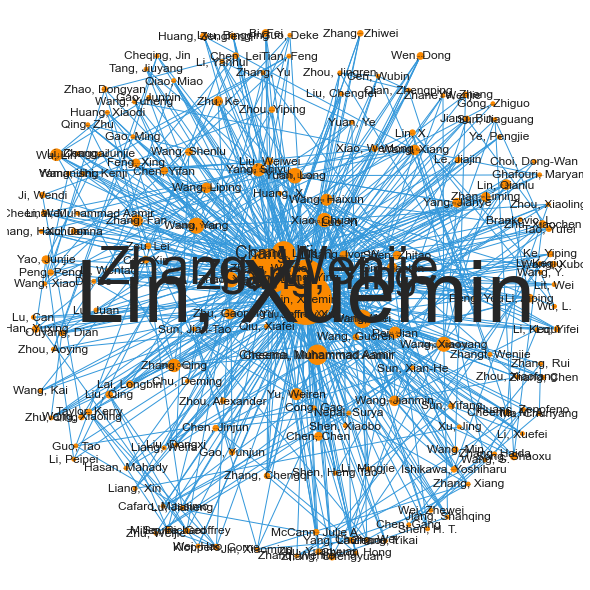

In [19]:
from matplotlib.pyplot import figure, text

# Just use sample data for final graphs
sample_rows = 200

# CREATE DICTIONARY OF AUTHORS ID + NAME
list_node_id = list(node_pairs_X['node_id'])
list_node_name = list(node_pairs_X['node_name'])
nodes_dict = dict(zip(list_node_id, list_node_name))
# nodes_dict

# DISABLING FOR FINAL MODELLING RUN
if 1==1:
    # NODES - CREATE list of Authors (nodes) purely for the Graph step
    nodes_for_graph = node_pairs_X[['author-1','weight']]
    nodes_for_graph

    nodes_sample = nodes_for_graph[0:sample_rows]

    sample_rows_auth = nodes_sample['author-1'].unique().tolist()
    edges_sample = df_edges_X[(df_edges_X['author-1'].isin(sample_rows_auth)) | (df_edges_X['author-2'].isin(sample_rows_auth))]

    # print('Sample data for final graph, too many can be unviewable')
    print(f'Network Graph up to {sample_rows} sample rows for Prof. Zhang data ({len(node_pairs_X)} original rows)')
    print("Node rows =",len(nodes_sample))
    print("Edge rows =",len(edges_sample))
    # edges_sample[0:20]

    #--------------------------------------------------------------------------
    # Visualise Co-Authors of Published Papers linked by Author ID (unique Name)
    # Basic graph version to help understand data, not interactive
    # colours: https://htmlcolorcodes.com/
    #--------------------------------------------------------------------------
    starttime = timeit.default_timer()

    clr_edge = '#3498DB'
    clr_node = '#FB8900'

    G = nx.Graph()  

    i=0
    for index, row in nodes_sample.iterrows():
        # node_id, size_author
        G.add_node(row['author-1'], nodesize=row['weight']*5)
        i+=1

    widths = []
    for index, row in edges_sample.iterrows():
        G.add_edges_from([(row['author-1'], row['author-2'])])
        # G.add_weighted_edges_from([(row['author-1'], row['author-2'], row['weight'])])
        # widths.append(row['weight'])

    # graph plot configuration
    plt.figure(figsize=(8,8))
    options = {
        'edge_color': clr_edge,
        'node_color': clr_node,
        'with_labels': False,
        'font_weight': 'regular',
    }

    # adjust this to vary the node size on the graph
    node_weight = 3
    sizes = [G.nodes[n]['nodesize']*node_weight if len(G.nodes[n].keys())>0 else 1 for n in G]
    #colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]

    """
    Using the spring layout : 
    - k controls the distance between the nodes and varies between 0 and 1
    - iterations is the number of times simulated annealing is run
    - default k=0.1 and iterations=50

    nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
    nx.draw(G, node_size=sizes, width=widths, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
    """
    pos=nx.spring_layout(G, k=1, iterations=50, seed=42)
    size = dict(node_pairs_X['weight'])
    lab = dict(node_pairs_X['node_name'])

    nx.draw(G, node_size=sizes, pos=pos, **options)
    nx.draw_networkx_labels(G, pos, nodes_dict)
    for node, (x, y) in pos.items():
        text(x, y, lab[node], fontsize=size[node]/2, ha='center', va='center')
    ax = plt.gca()
    ax.collections[0].set_edgecolor(clr_node) 
    plt.show();

    # only show time taken if over 1 min
    if (timeit.default_timer() - starttime)>60:
        print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

## 19. CREATE GRAPH FUNCTIONS that we can re-use with different data
- CREATE NODE-HOPPING FUNCTIONS - to calculate N-Hops between Nodes, up to max hop (ie: cutoff)
- These 2 functions are similar - but the node_hops_lc is purely for list comprehension later

In [20]:
def network_graph(df_edges, nodes_for_graph, show=False, auth_index=None, min_weight=0):
    starttime = timeit.default_timer()
    # SAMPLE DATA if specified
    if auth_index!=None:
        # only edges where author-1, author-2 are in the sample list
        nodes_for_graph = nodes_for_graph[((nodes_for_graph['author-1'].isin(auth_index)) | (nodes_for_graph['author-2'].isin(auth_index))) & (nodes_for_graph['weight']>min_weight)]
        df_edges = df_edges[((df_edges['author-1'].isin(auth_index)) | (df_edges['author-2'].isin(auth_index))) & (df_edges['weight']>min_weight)]
     
    # NODES WEIGHTED
    i=0
    for index, row in nodes_for_graph.iterrows():
        G.add_node(row['author-1'], nodesize=row['weight']*3)
        i=i+1

    # EDGES WEIGHTED
    widths = []
    for index, row in df_edges.iterrows():
        #G.add_weighted_edges_from([(row['author-1'], row['author-2'], row['weight'])])
        G.add_edges_from([(row['author-1'], row['author-2'])])
        #widths.append(row['weight']/5)

    if auth_index!=None:
        print('sample nodes:',len(nodes_for_graph))
        print('sample edges:',len(df_edges))
        
    clr_edge = '#3498DB'
    clr_node = '#FB8900'

    # only show graph if request, eg: sample data
    if show==True:
        # configure Plot for viewint
        plt.figure(figsize=(7,7))
        options = {
            'edge_color': clr_edge,
            'node_color': clr_node,
            'with_labels': True,
            'font_weight': 'regular',
        }

        # Adjust the size of the node
        node_weight = 3
        #colors = [color_map[G.nodes[n]['group']] if len(G.nodes[n].keys())>0 else '#FFDEA2' for n in G]
        sizes = [G.nodes[n]['nodesize']*node_weight if len(G.nodes[n].keys())>0 else 1 for n in G]

        """
        Using the spring layout : 
        - k controls the distance between the nodes and varies between 0 and 1
        - iterations is the number of times simulated annealing is run
        - default k=0.1 and iterations=50

        nx.draw(G, node_size=sizes, width=widths, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
        nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
        """

        nx.draw(G, node_size=sizes, pos=nx.spring_layout(G, k=1, iterations=50, seed=42), **options)
        ax = plt.gca()
        ax.collections[0].set_edgecolor(clr_node) 
        plt.show()
    
    if (timeit.default_timer() - starttime)>60:
        print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

    return G

#----------------------------------------------------------------------
# This version is for using individually, when testing known or specific author pairings
#----------------------------------------------------------------------
def node_hops(G, source_node, target_node, cutoff=3, show=False):
    n_hop = nx.single_source_shortest_path_length(G, source_node, cutoff=n_hop_max)
    result = n_hop.get(target_node) if n_hop.get(target_node)!=None else 0
    
    # print output only if show = True
    if show==True:
        # print(f'{cutoff}-hop nodes between ({source_node}, {target_node}) connected to {len(n_hop)} authors\n\n', n_hop,'\n')
        if result==0:
            print(f'Node hops: source node ({source_node}),\t target ({target_node})\t= None')
        elif result==1:
            print(f'Node hops: source node ({source_node}),\t target ({target_node})\t= {n_hop.get(target_node)} hop')
        else:
            print(f'Node hops: source node ({source_node}),\t target ({target_node})\t= {n_hop.get(target_node)} hops')
        
    return result;

#----------------------------------------------------------------------
# This version is to use in the List Comprehension step to apply to the whole dataset
# reason is to make life easier by using a global Graph object, but passing in individual A1, A2 elements
# cutoff (n_hop_max) we will hardcode to 5
#----------------------------------------------------------------------
def node_hops_lc(G_full, source_node, target_node, cutoff=5):    
    n_hop = nx.single_source_shortest_path_length(G_full, source_node, cutoff=cutoff)
    result = n_hop.get(target_node) if n_hop.get(target_node)!=None else 0    
    return result;


# G_auth = network_graph(df_edges, nodes_for_graph, show=True)    

## 20. Read in Nodes & Edges data (in case of kernal restart)
- All unique authors: nodes_for_graph
- All existing 1-to-1 coauthor pairings: df_edges
- All A1,A2 pairings both linked and unlinked

In [21]:
# Graph data but for ALL authors, including non-coauthor linked, ie: 1.1million edges

if 1==2:
    # NODES - necessary if restaring code from this section - it returns the same as existing code above if NO crashing occurs
    node_pairs = pd.read_csv('coauthor_nodes.csv', skiprows=0, low_memory=False)
    nodes_for_graph = node_pairs[['author-1','weight']].copy()

    # EDGES - only the linked 1 to 1 coauthors    
    df_edges = pd.read_csv('coauthor_edges.csv', skiprows=0, low_memory=False)
    df_edges.columns = ('author-1','author-2','weight')

    # ALL AUTHOR PAIRINGS - linked and unlinked, 1.1 mill for max co-author = 5
    all_authors_merge = pd.read_csv('coauthor_all_paired.csv', skiprows=0, low_memory=False)
    df_node_author = pd.read_csv('df_node_author.csv', skiprows=0, low_memory=False)

    print('Graph data for all possible author combinations - linked and unlinked')
    print("Unique author (node) rows =",len(nodes_for_graph))
    print("Relationship  (edge) rows =",len(df_edges))
    print("ALL Unique authors   rows =",len(df_node_author))
    print("All Author-Pairs     rows =",len(all_authors_merge),' (linked and unlinked)')

### 20.1 CREATE Graph Object and calulate N-hops - for ALL node pairings, including not yet connected
- All unique authors: all_authors_merge (all authors in dataset)
- All existing 1-to-1 coauthor pairings: df_edges
#### G_full returns the Graph object for all node pairings, including non connected - DO NOT SHOW GRAPH if running full 2.9 million rows, ie: show=False
#### SAVE TO CSV for Topic Modelling
- THIS LAST STEP CREATES THE FEATURES-X, and, TARGET-Y data for the PREDICTIVE MODELLING STEPS   
- df_auth_hop_y - will derived the model's Target value "has worked together" 
- based on 2019/20/21 Pub Year coauthored one-to-one (n_hop 1 = Yes) or not coauthored (n_hop is None or > 1) 

In [22]:
# CREATE Graph Object - Connected Authors only - as input for Networkxx API functions
# This is a global variable also used in the list comprehension function: node_hops_lc()
# G_auth = network_graph(df_edges, nodes_for_graph, show=True)

# CREATE Graph Object - as input for Networkxx API functions
# This is a global variable also used in the list comprehension function: node_hops_lc()
# SUPER QUICK if not showing graph picture

def calculate_n_hops(func_title, all_authors_merge, df_node_author, df_edges):
    starttime = timeit.default_timer()

    all_authors_nodes = all_authors_merge[['author-1','author-2','weight_10_years']].copy()
    all_authors_nodes.columns = ['author-1','author-2','weight']
    all_authors_nodes['weight'] = [int(x) for x in all_authors_nodes['weight']]

    df_node_author['weight'] = df_node_author['size_author']
    df_node_author['author-1'] = df_node_author['node_id'] 

    # Create Graph object - required for Graph functions, eg: shortest path (n_hop)
    G_full = network_graph(df_edges, df_node_author, show=False)

    #----------------------------------------------------------------------
    # CALCULATE N_HOPS FOR ALL AUTHOR PAIRS IN OUR CITATIONS DATA
    #----------------------------------------------------------------------

    # All A1,A2 pairings, full dataset, linked co-authors and non linked
    df_auth_hop = all_authors_merge.copy()

    # list comprehension to apply function node_hops_lc() to all rows
    df_auth_hop['n_hop'] = [node_hops_lc(G_full, A1, A2, cutoff=7) for A1,A2 in zip(df_auth_hop['author-1'],df_auth_hop['author-2'])]
    
    print(f'\n{func_title} data')
    print('Time taken is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes')
    print(f'Generate n-hop values for the {len(df_auth_hop)} {func_title} connections:')
    print(df_auth_hop.groupby('n_hop')['n_hop'].count())

    # Time taken is : 27.20 seconds for 114481 auth-pair rows 
    # Generate n-hop values for 11781 rows
    # Time taken is : 2.46 seconds / 0.04 minutes

    print('len(df_auth_hop.cols',len(df_auth_hop.columns))
    # VIEW N-HOP RESULTS FOR ALL A1,A2 PAIRS - show only where N_hop is not 0
    # df_auth_hop = df_auth_hop[['auth-pair','author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','Y19','Y20','Y21','a1_papers','a2_papers','n_hop']]
    if len(all_authors_merge.columns)>12:
        # features data
        df_auth_hop = df_auth_hop[['auth-pair','author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18','a1_papers','a2_papers','n_hop']]
    else:
        # target data 
        df_auth_hop = df_auth_hop[['auth-pair','author-1','author-2','weight_2_years','weight_5_years','weight_10_years','Y19','Y20','Y21','a1_papers','a2_papers','n_hop']]
        
    print(f'       Total Author A1,A2 pair rows = {len(df_auth_hop)}\n       Sample rows ({len(df_auth_hop[df_auth_hop["n_hop"]!=0])}) where n_hop is not 0 (ie: 1 to 3)')

    #----------------------------------------------------------------------
    # save to CSV for Topic Modelling - o 
    df_auth_hop.to_csv(f'df_auth_hop_{func_title}.csv', index=0)    
    
    return df_auth_hop

    
""" THIS LAST STEP CREATES THE FEATURES-X, and, TARGET-Y data for the PREDICTIVE MODELLING STEPS               """  
""" df_auth_hop_y - will derived the model's Target value "has worked together"                                """
""" ased on 2019/20/21 Pub Year coauthored one-to-one (n_hop 1 = Yes) or not coauthored (n_hop is None or > 1) """

#---------------------------------------------------------
# SPLIT FEATURE YEARS 2011-2017 AND TARGET YEARS 2019-2021  
df_auth_hop_X = calculate_n_hops('features', all_authors_merge_X, df_node_author_X, df_edges_X) 
df_auth_hop_y = calculate_n_hops('target', all_authors_merge_y, df_node_author_y, df_edges_y) 

# for viewing only - n_hop>0 (output same number of rows even without the n_hop>0 filter)
print('\nN-hop > 0')
df_auth_hop_X[df_auth_hop_X['n_hop']>0].sort_values('n_hop', ascending=False)



features data
Time taken is : 4.53 seconds / 0.08 minutes
Generate n-hop values for the 14535 features connections:
n_hop
1      669
2    11919
3     1456
4      479
5       12
Name: n_hop, dtype: int64
len(df_auth_hop.cols 18
       Total Author A1,A2 pair rows = 14535
       Sample rows (14535) where n_hop is not 0 (ie: 1 to 3)

target data
Time taken is : 3.16 seconds / 0.05 minutes
Generate n-hop values for the 8778 target connections:
n_hop
1     878
2    7772
3     128
Name: n_hop, dtype: int64
len(df_auth_hop.cols 13
       Total Author A1,A2 pair rows = 8778
       Sample rows (8778) where n_hop is not 0 (ie: 1 to 3)

N-hop > 0


,auth-pair,author-1,author-2,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers,n_hop
6667,"112,115",112,115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,5
11141,"115,149",115,149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,5
11147,"121,149",121,149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,5
13324,"121,163",121,163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,5
11058,"32,149",32,149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,"150,164",150,164,0.0,6.0,12.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,83,6,1
11812,"31,154",31,154,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,1
6366,"38,113",38,113,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,13,1
2930,"4,77",4,77,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2,1


Number of author-pairs (connected and not-connected): 14535


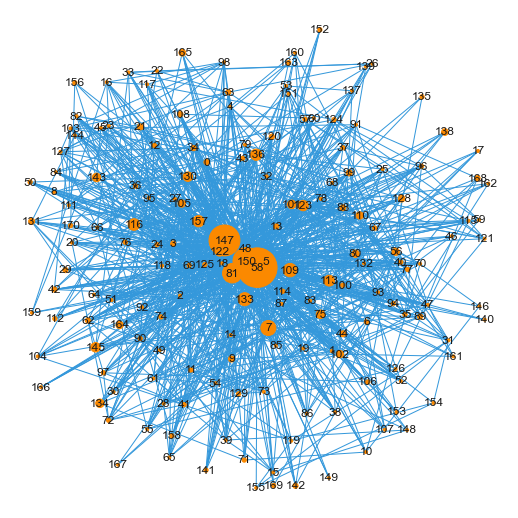

Node hops: source node (7),	 target (177)	= None
Node hops: source node (110),	 target (185)	= None
Node hops: source node (140),	 target (69)	= 2 hops
Node hops: source node (55),	 target (161)	= 2 hops
Node hops: source node (50),	 target (46)	= 2 hops
Node hops: source node (50),	 target (46)	= 2 hops
Node hops: source node (50),	 target (185)	= None


In [24]:
# TESTING - how many N-hops for sample author-pairs
n_hop_max = 7

nodes_for_graph = all_authors_merge_X[['author-1','author-2','weight_10_years']]
nodes_for_graph.columns=['author-1','author-2','weight']
print('Number of author-pairs (connected and not-connected):',len(nodes_for_graph))

#auth_index=[110,153,114,153,152,102,185,89,121,72,5]
#G_auth = network_graph(df_edges, nodes_for_graph, show=True, auth_index=auth_index)

G_full = network_graph(df_edges_X, df_node_author_X, show=True)

# compare n-hops on known linked authors - check df_edges contents for pair examples
n_hop = node_hops(G_full, source_node=7, target_node=177, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=110, target_node=185, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=140, target_node=69, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=55, target_node=161, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=50, target_node=46, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=50, target_node=46, cutoff=n_hop_max, show=True)
n_hop = node_hops(G_full, source_node=50, target_node=185, cutoff=n_hop_max, show=True)

#auth_index=[4473,5147]
#all_authors_nodes[(all_authors_nodes['author-1']==4473) & (all_authors_nodes['weight']>0)]

In [25]:
# example authors not worked together
# all_authors_merge[(all_authors_merge['author-1']==114) & (all_authors_merge['author-2']==156)]

# quick check how single_source_shortest_path_length() works - API returns all linked nodes up to cut-off (n_hop_max) in dictionary format
# source_node = 4
# n_hop_max = 3
# n_hop = nx.single_source_shortest_path_length(G_full, source_node, cutoff=n_hop_max)
# print(f'Source author : {source_node}\nconnected to  : {len(n_hop)} authors\nwithin        : {n_hop_max} hops','\n\n',n_hop)

# example authors HAVE worked together
all_authors_merge_X[all_authors_merge_X['author-2']==133].sort_values('Y16', ascending=False)

,author-1,author-2,auth-pair,auth-pair-rev,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers
8836,58,133,"58,133","133,58",36.0,132.0,216.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0,12.0,174,19
8859,81,133,"81,133","133,81",30.0,90.0,130.0,2.0,2.0,2.0,2.0,2.0,2.0,10.0,10.0,42,19
8783,5,133,"5,133","133,5",6.0,36.0,48.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,6.0,35,19
8847,69,133,"69,133","133,69",2.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2,19
8842,64,133,"64,133","133,64",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8817,39,133,"39,133","133,39",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
8816,38,133,"38,133","133,38",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,19
8815,37,133,"37,133","133,37",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,19
8814,36,133,"36,133","133,36",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,19


## 21. Topic Similarity

In [26]:
# Load extra requirements
import pandas as pd
import numpy as np
import scipy
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import itertools
import timeit
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

##################  If just want to run this section, import the file produced by above code
#os.chdir('C:\\MDSI\\2021\SINA\Group assign')

if 1==2:
    df_pub_auth_subset_X = pd.read_csv('df_pub_auth_subset_features.csv')
    df_auth_hop_X = pd.read_csv('df_auth_hop_features.csv')
    print('len df_pub_auth_subset_features',df_pub_auth_subset_X.shape)
    print('len df_auth_hop_features       ',df_auth_hop_X.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paipac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 22. Do similarity scores for these papers

In [27]:
# Get the subset of papers for our conditions i.e. no. authors <=5 and relevant papers only in past 10 years
papers10 = df_pub_auth_subset_X[df_pub_auth_subset_X['Pub Year'] > 2010][['Publication ID','Times Cited','Pub Year','Authors_Split','# Authors','Author','index_author','Author Total Papers']]

print('len(papers10',papers10.shape)
papers10

len(papers10 (908, 8)


,Publication ID,Times Cited,Pub Year,Authors_Split,# Authors,Author,index_author,Author Total Papers
0,pub.1110506917,2,2018,"[Wang, Xubo, Qin, Lu, Lin, Xuemin, Zhang, Ying...",5,"Wang, Xubo",114,2
1,pub.1110419433,0,2018,"[Lin, Xuemin]",1,"Lin, Xuemin",58,174
2,pub.1111651043,1,2018,"[Zhang, Junjie, Wang, Liping, Zhang, Wenjie, Y...",4,"Zhang, Junjie",144,1
3,pub.1109824256,6,2018,"[Zhang, Fan, Li, Conggai, Zhang, Ying, Qin, Lu...",5,"Zhang, Fan",143,8
4,pub.1107774855,5,2018,"[Zhu, Weijie, Chen, Chen, Wang, Xiaoyang, Lin,...",4,"Zhu, Weijie",167,1
...,...,...,...,...,...,...,...,...
37,pub.1091840060,0,2017,"[Jiang, Shanqing, Zhang, Chengyuan, Zhang, Yin...",7,"Wang, Xiaoyang",113,13
134,pub.1095297482,0,2013,"[Chen, Jinjun, Nepal, Surya, Cafaro, Massimo, ...",8,"Chen, Jinjun",11,2
137,pub.1048810164,2,2013,"[Liu, Qing, Zhao, Xiang, Taylor, Kerry, Lin, X...",7,"Miller, Richard",72,2
158,pub.1014620872,2,2013,"[Liu, Qing, Taylor, Kerry, Zhao, Xiang, Squire...",7,"Miller, Richard",72,2


## 23. Here we collect all papers required using the conditions:

In [28]:
# Here we collect all papers in the dataset used above:
pubs = df_pub_auth_subset_X['Publication ID'].unique()

# reoload raw file so we get the abstracts text back
# Carol's:
#doc_dv = file_url + 'Dimensions-Publication-2021-04-18_09-17-17.csv'
data2 = pd.read_csv(doc_dv, skiprows=1, low_memory=False)

# And filter for papers suiting above conditions
papers10_subset = data2.loc[data2['Publication ID'].isin(pubs)]
print('len(papers10_subset',papers10_subset.shape)

len(papers10_subset (197, 15)


## 24. Process the publications into usable for topic modelling
1293 total papers drops down to 1001 due to no abstract available

In [29]:
# Remove the publications with no abstract and add a column to show row number
# 1293 total paper rows drops down to 1001
papers10_subset = papers10_subset.dropna(subset=['Abstract'])  # Abstract
papers10_subset['RN'] = np.arange(papers10_subset.shape[0])

# Prepare text for processing
# Remove punctuation
papers10_subset['Abstract_processed'] = papers10_subset['Abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers10_subset['Abstract_processed2'] = papers10_subset['Abstract_processed'].map(lambda x: x.lower())


# Prepare for LDA by tokenising text and removing stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'using', 'used', 'pm', 'eg', 'study', 'studies', 'data', 'based'])

def sent_to_words(sentences):
    for sentence in sentences:
# deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

abs_set = papers10_subset.Abstract_processed2.values.tolist()
found_words = list(sent_to_words(abs_set))

# remove stop words
found_words = remove_stopwords(found_words)

# Now convert the tokenised text into corpus and dictionary
# Create Dictionary
id2word = corpora.Dictionary(found_words)
# Create Corpus
texts = found_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## 28. Do Topic Modelling
### Number of topics is restricted to 10, given the absracts are fairly short (rather than a whole article) and the subject matter is restricted to certain fields

In [30]:
# Given the absracts are fairly short (rather than a whole article) and the subject matter is restricted to certain fields we'll limit the number of topics we arbitrarily pick to be 10

# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,minimum_probability=0.0)
# Print the Keyword in the 10 topics
print(lda_model.print_topics(num_words=15))
doc_lda = lda_model[corpus]

[(0, '0.039*"usepackage" + 0.017*"document" + 0.016*"pt" + 0.010*"graph" + 0.010*"algorithm" + 0.008*"algorithms" + 0.008*"skyline" + 0.008*"amsbsy" + 0.007*"amsfonts" + 0.007*"mathrsfs" + 0.007*"setlength" + 0.007*"top" + 0.007*"amssymb" + 0.006*"documentclass" + 0.006*"wasysym"'), (1, '0.010*"objects" + 0.009*"paper" + 0.008*"set" + 0.008*"graph" + 0.007*"algorithm" + 0.007*"problem" + 0.007*"similarity" + 0.007*"time" + 0.006*"real" + 0.006*"algorithms" + 0.006*"existing" + 0.005*"proposed" + 0.005*"techniques" + 0.005*"spatial" + 0.005*"two"'), (2, '0.034*"usepackage" + 0.012*"query" + 0.010*"document" + 0.009*"pt" + 0.008*"set" + 0.008*"objects" + 0.008*"techniques" + 0.007*"uncertain" + 0.007*"efficient" + 0.007*"algorithms" + 0.007*"similarity" + 0.007*"problem" + 0.006*"paper" + 0.006*"documentclass" + 0.006*"applications"'), (3, '0.010*"graph" + 0.009*"usepackage" + 0.009*"algorithms" + 0.009*"approach" + 0.008*"paper" + 0.007*"similarity" + 0.007*"techniques" + 0.007*"set" + 

## 29. Calcualte the J-S distances between all pairs of documents in the selected publications

In [31]:
# Create an array for the probability weights per topic for each publication
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda_model[corpus]])
print('doc_topic_dist',doc_topic_dist.shape)

p_sim = []  # <= missing 

for i in range(0,len(doc_topic_dist)):
        for j in range(0,len(doc_topic_dist)):
                p = doc_topic_dist[i]
                q = doc_topic_dist[j]
                sim = scipy.spatial.distance.jensenshannon(p,q)
                p_sim.append([i, j, sim])

# len(p_sim) = 1002001
# Convert the list to a dataframe for further work
sim_df = pd.DataFrame(p_sim, columns = ['P1','P2','Sim'])

sim_df.info()
sim_df.tail()

doc_topic_dist (188, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35344 entries, 0 to 35343
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   P1      35344 non-null  int64  
 1   P2      35344 non-null  int64  
 2   Sim     35344 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 828.5 KB


,P1,P2,Sim
35339,187,183,0.821788
35340,187,184,0.819839
35341,187,185,0.822446
35342,187,186,0.822262
35343,187,187,0.000000


## 30. Lookup the actual publication numbers which relate to the similarity scores

In [33]:
# Now lookup the actual publication numbers which relate to the similarity scores
pub_num= papers10_subset[['RN','Publication ID']]
sim_pubs= pd.merge(pub_num,sim_df,left_on='RN',right_on='P1')
sim_pubs= sim_pubs.drop(['RN','P1'], axis=1)
sim_pubs= sim_pubs.rename(columns = {'Publication ID' : 'Pub1'})
sim_pubs= pd.merge(pub_num,sim_pubs,left_on='RN',right_on='P2')
sim_pubs= sim_pubs.drop(['RN','P2'], axis=1)
sim_pubs= sim_pubs.rename(columns = {'Publication ID' : 'Pub2'})
sim_pubs[['Pub1','Pub2']]= sim_pubs[['Pub1','Pub2']].astype(str) #'string')
sim_pubs.head(5)

,Pub2,Pub1,Sim
0,pub.1110506917,pub.1110506917,0.000000
1,pub.1110506917,pub.1111651043,0.808850
2,pub.1110506917,pub.1109824256,0.825029
3,pub.1110506917,pub.1107774855,0.789827
4,pub.1110506917,pub.1106974269,0.088497


## 31. We want to find similarity of the papers written by author pairs who are between 2 and max_n-hops away from connected authors 
#### i.e. the author pair distance measures for the pairs relevant to prediction model. 

- To do that we first find the unique authors involved in those 2-to-n hop pairs and get the papers they worked on. 
- Then can obtain similarity-distance scores for just those author pairs. 
- Pairs which have already worked together i.e. 1-hop will have a distance score of 0

### 31.1 Identify all papers any individual author has worked on

In [35]:
# Firstly, identify all papers any individual author has worked on
#auth_pubs = papers10.groupby('index_author')['Publication ID'].apply(','.join).reset_index()
auth_pubs = df_pub_auth_subset_X.groupby('index_author')['Publication ID'].apply(','.join).reset_index()
auth_pubs[0:5]

,index_author,Publication ID
0,0,"pub.1104577947,pub.1012191761,pub.1039529247"
1,1,pub.1061662235
2,2,pub.1095297482
3,3,"pub.1107851959,pub.1085385658,pub.1103956067"
4,4,pub.1106923116


### 31.2 Find unique authors involved in the 2-to-n hop pairs

In [36]:
print('count hop >1 up to total 7   =',df_auth_hop_X.groupby('n_hop')['n_hop'].count(),'\n')
print('df_auth_hop >1 up to total 7 =', len(df_auth_hop_X[(df_auth_hop_X['n_hop'] > 1)]))
print('df_auth_hop >1 and <= 3      =', len(df_auth_hop_X[(df_auth_hop_X['n_hop'] > 1) & (df_auth_hop_X['n_hop'] <= 3)]))
df_auth_hop_X[(df_auth_hop_X['n_hop'] > 1) & (df_auth_hop_X['n_hop'] <= 3)]

count hop >1 up to total 7   = n_hop
1      669
2    11919
3     1456
4      479
5       12
Name: n_hop, dtype: int64 

df_auth_hop >1 up to total 7 = 13866
df_auth_hop >1 and <= 3      = 13375


,auth-pair,author-1,author-2,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers,n_hop
0,"0,1",0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2
1,"0,2",0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2
2,"1,2",1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,2
3,"0,3",0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,2
4,"1,3",1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14530,"165,170",165,170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2,2
14531,"166,170",166,170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,2
14532,"167,170",167,170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,2
14533,"168,170",168,170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,2


In [37]:
# Bring in the 2-t-n hop pairs and features but remove the most prolific authors
hop_2_n= df_auth_hop_X[df_auth_hop_X['n_hop'] > 1]
hop_2_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13866 entries, 0 to 14534
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   auth-pair        13866 non-null  object 
 1   author-1         13866 non-null  int64  
 2   author-2         13866 non-null  int64  
 3   weight_2_years   13866 non-null  float64
 4   weight_5_years   13866 non-null  float64
 5   weight_10_years  13866 non-null  float64
 6   Y11              13866 non-null  float64
 7   Y12              13866 non-null  float64
 8   Y13              13866 non-null  float64
 9   Y14              13866 non-null  float64
 10  Y15              13866 non-null  float64
 11  Y16              13866 non-null  float64
 12  Y17              13866 non-null  float64
 13  Y18              13866 non-null  float64
 14  a1_papers        13866 non-null  int64  
 15  a2_papers        13866 non-null  int64  
 16  n_hop            13866 non-null  int64  
dtypes: float64(1

### 31.5 Convert to df and bring in all papers done by each author pair member

In [38]:
# Convert to df and bring in all papers done by each author pair member
used_pairs = hop_2_n[['auth-pair','author-1','author-2']]
paps1= pd.merge(used_pairs,auth_pubs,how='left',left_on='author-1',right_on='index_author')
paps1= paps1.drop('index_author', axis=1)
paps1= paps1.rename(columns = {'Publication ID' : 'Pub_A1'})
paps2= pd.merge(used_pairs,auth_pubs,how='left',left_on='author-2',right_on='index_author')
paps2= paps2.drop('index_author', axis=1)
paps2= paps2.rename(columns = {'Publication ID' : 'Pub_A2'})
pair_paps = pd.merge(paps1,paps2,how='left',on=['auth-pair','author-1','author-2'])
print(pair_paps.info())
pair_paps.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13866 entries, 0 to 13865
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   auth-pair  13866 non-null  object
 1   author-1   13866 non-null  int64 
 2   author-2   13866 non-null  int64 
 3   Pub_A1     13866 non-null  object
 4   Pub_A2     13866 non-null  object
dtypes: int64(2), object(3)
memory usage: 650.0+ KB
None


,auth-pair,author-1,author-2,Pub_A1,Pub_A2
0,"0,1",0,1,"pub.1104577947,pub.1012191761,pub.1039529247",pub.1061662235
1,"0,2",0,2,"pub.1104577947,pub.1012191761,pub.1039529247",pub.1095297482
2,"1,2",1,2,pub.1061662235,pub.1095297482
3,"0,3",0,3,"pub.1104577947,pub.1012191761,pub.1039529247","pub.1107851959,pub.1085385658,pub.1103956067"
4,"1,3",1,3,pub.1061662235,"pub.1107851959,pub.1085385658,pub.1103956067"


### 31.6 Split out the different papers per author. This is the start of creating all pairs of papers for similarity comparisons
- What are the largest number of papers worked on by any author?


In [39]:
# Split out the different papers per author. This is the start of creating all pairs of papers for similarity comparisons
A1_pubs= np.array(pair_paps.Pub_A1.str.split(","))
A2_pubs= np.array(pair_paps.Pub_A2.str.split(","))
print(A1_pubs[:5])
print(A2_pubs[:5])
print('')

# What are the largest number of papers worked on by any author?
print('len(max(A1_pubs, key=len))',len(max(A1_pubs, key=len)))
print('len(max(A2_pubs, key=len))',len(max(A2_pubs, key=len)))

[list(['pub.1104577947', 'pub.1012191761', 'pub.1039529247'])
 list(['pub.1104577947', 'pub.1012191761', 'pub.1039529247'])
 list(['pub.1061662235'])
 list(['pub.1104577947', 'pub.1012191761', 'pub.1039529247'])
 list(['pub.1061662235'])]
[list(['pub.1061662235']) list(['pub.1095297482'])
 list(['pub.1095297482'])
 list(['pub.1107851959', 'pub.1085385658', 'pub.1103956067'])
 list(['pub.1107851959', 'pub.1085385658', 'pub.1103956067'])]

len(max(A1_pubs, key=len)) 174
len(max(A2_pubs, key=len)) 174


## 31.7 Match up all pairwise combinations of papers for Author 1 with papers for Author 2
- This will allow us to pull similarity distance scores and find how close the closest two papers they each did are


In [40]:
# Match up all pairwise combinations of papers for Author 1 with papers for Author 2
# This will allow us to pull similarity distance scores and find how close the closest two papers they each did are
pair_sim = []

for i in range(0,len(pair_paps)):
    AP1= A1_pubs[i]
    AP2= A2_pubs[i]
    all_combo = list(itertools.product(AP1,AP2))
    pair_sim.append(all_combo)
print(len(pair_sim))
pair_sim[0:5]

13866


[[('pub.1104577947', 'pub.1061662235'),
  ('pub.1012191761', 'pub.1061662235'),
  ('pub.1039529247', 'pub.1061662235')],
 [('pub.1104577947', 'pub.1095297482'),
  ('pub.1012191761', 'pub.1095297482'),
  ('pub.1039529247', 'pub.1095297482')],
 [('pub.1061662235', 'pub.1095297482')],
 [('pub.1104577947', 'pub.1107851959'),
  ('pub.1104577947', 'pub.1085385658'),
  ('pub.1104577947', 'pub.1103956067'),
  ('pub.1012191761', 'pub.1107851959'),
  ('pub.1012191761', 'pub.1085385658'),
  ('pub.1012191761', 'pub.1103956067'),
  ('pub.1039529247', 'pub.1107851959'),
  ('pub.1039529247', 'pub.1085385658'),
  ('pub.1039529247', 'pub.1103956067')],
 [('pub.1061662235', 'pub.1107851959'),
  ('pub.1061662235', 'pub.1085385658'),
  ('pub.1061662235', 'pub.1103956067')]]

## 32. ADD THE AUTHOR SIMILARITY SCORE TO THE FULL DF FOR USE IN PREDICTIVE MODEL
- The total size is too large so iterate in pieces, soet size of batch & find number of batches

In [41]:
########################
############################## THIS TAKES A WHILE SO ONLY RUN ONCE FOR EACH TIME YOU CHANGE THE DATA
############################## OTHERWISE USE THE IMPORT CSV CELL ABOVE

# If want to lood pre-saved distance scores
# all_auth_sim= pd.read_csv('all_auth_sim_Zhang.csv')]

# In case the total size is too large, this iterates in pieces
# Set size of batch 
single = 1000

# And set an empty df to accumulate all of the final similarity distance scores between authors
all_auth_sim= pd.DataFrame()

print('Processing for pair_sim =',len(pair_sim))

starttime = timeit.default_timer()
# set batches of pairs of papers until completed
for i in range(0, len(pair_sim), single):
    part = min(len(pair_sim),i + single)
    pair_sim_sm = pair_sim[i:part]
    # Convert to df and name columns
    pair_sim_df=pd.DataFrame(pair_sim_sm).astype(str) #'string')
    pair_sim_df.columns=["Pub_pair_"+str(i) for i in range(0, pair_sim_df.shape[1])]
    # First remove punctuation in the publications list
    for n in range(0, len(pair_sim_df.columns)):
        pair_sim_df.iloc[:,n] = pair_sim_df.iloc[:,n].str.replace('[)(\']', '')
    # Split the pairs of papers into individual columns for matching to similarity distance df
    for k in range(0,len(pair_sim_df.columns)):
        pair_sim_df[['Pub1_' +str(k), 'Pub2_'+str(k)]] = pair_sim_df.iloc[:,0].str.split(', ', expand=True)
        pair_sim_df= pair_sim_df.drop('Pub_pair_'+str(k), axis=1)
    # Pick up all relevant scores for an author pair (row)
    #set an empty df
    collect = pd.DataFrame()
    #Collect similarity scores per paper pair
    print('similarity scores pair_sim_df columns', len(pair_sim_df.columns))
    for m in range(0,len(pair_sim_df.columns),2):
        pp = pair_sim_df.iloc[:,m:m+2]
        pp.columns = ['Pub1','Pub2']
        collect[['Pub1_'+str(m), 'Pub2_'+str(m),'Sim_'+str(m)]]= pd.merge(pp, sim_pubs,  how='left', on=['Pub1','Pub2'])
        ##### THIS IS THE MAGICAL PIECE THAT FINDS THE MINIMUM DISTANCE BETWEEN PAPERS THE 2 AUTHORS HAVE WORKED ON !!
        collect['Min_dist'] = collect.filter(regex='^Sim',axis=1).min(axis=1)
        # Attach the distance measure explicitly to the author pair, for final model use
        pair_paps_sm = pair_paps[i:part]
        pair_paps_sm = pair_paps_sm.reset_index(drop=True)
        collect = collect.reset_index(drop=True)
        pair_paps_sm['Min_dist']= collect['Min_dist']
        pair_paps_sm = pair_paps_sm.drop(['Pub_A1', 'Pub_A2'], axis=1)
    
    # AND FINALLY ADD THE AUTHOR SIMILARITY SCORE TO THE FULL DF FOR USE IN PREDICTIVE MODEL
    all_auth_sim = pd.concat([all_auth_sim, pair_paps_sm])
    print('Round starting at ' +str(i)+ ' done')


if (timeit.default_timer() - starttime) > 0:
    print('\nTotal time is : {:0.2f}'.format(timeit.default_timer() - starttime), 'seconds','/','{:0.2f}'.format((timeit.default_timer() - starttime)/60),'minutes\n')

print(all_auth_sim.info())
print(all_auth_sim.head(10))
all_auth_sim.to_csv('all_auth_sim_Zhang.csv')

Processing for pair_sim = 13866
similarity scores pair_sim_df columns 280
Round starting at 0 done
similarity scores pair_sim_df columns 696
Round starting at 1000 done
similarity scores pair_sim_df columns 400
Round starting at 2000 done
similarity scores pair_sim_df columns 2100
Round starting at 3000 done
similarity scores pair_sim_df columns 672
Round starting at 4000 done
similarity scores pair_sim_df columns 1680
Round starting at 5000 done
similarity scores pair_sim_df columns 1260
Round starting at 6000 done
similarity scores pair_sim_df columns 1008
Round starting at 7000 done
similarity scores pair_sim_df columns 950
Round starting at 8000 done
similarity scores pair_sim_df columns 560
Round starting at 9000 done
similarity scores pair_sim_df columns 2490
Round starting at 10000 done
similarity scores pair_sim_df columns 1176
Round starting at 11000 done
similarity scores pair_sim_df columns 696
Round starting at 12000 done
similarity scores pair_sim_df columns 636
Round star

## 33. Add the author similarity distance score to the full df created earlier for modelling
- create y target dataset also

In [42]:
# Cut the total author matrix to just 1-to-n hop pairs
hop_1_n = df_auth_hop_X[df_auth_hop_X['n_hop'] > 0]
# Add the topic distance column to the df with other variables
hop_1_n = pd.merge(hop_1_n, all_auth_sim, how = 'left', on= 'auth-pair')
hop_1_n = hop_1_n.drop(['author-1_y', 'author-2_y'], axis=1)
hop_1_n.rename(columns = {'author-1_x':'author-1', 'author-2_x':'author-2'}, inplace = True)
# Populate the Min_dist column with 0 for the 1-hop pairs, as these were not in similarity modelling i.e. they have a score of 0 becaause have done same paper
hop_1_n.Min_dist[hop_1_n['n_hop'] == 1] = 0

# backup to CSV so can rerun from this point
hop_1_n.to_csv('hop_1_n.csv', index=0)

hop_1_n.sort_values('Y18',ascending=False)

,auth-pair,author-1,author-2,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers,n_hop,Min_dist
11322,"147,150",147,150,192.0,528.0,880.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,106,83,1,0.000000
10789,"58,147",58,147,320.0,992.0,1472.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,174,106,1,0.000000
11233,"58,150",58,150,384.0,816.0,1136.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,174,83,1,0.000000
11182,"7,150",7,150,26.0,104.0,208.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,13.0,25,83,1,0.000000
1660,"7,58",7,58,24.0,132.0,276.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0,12.0,25,174,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,"24,99",24,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,2,0.816259
4876,"25,99",25,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.237957
4877,"26,99",26,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.140780
4878,"27,99",27,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.556777


## 34. Add a feature for the degree of connectedness for each pair of authors i.e. sum of edge weights for the pair

In [43]:
# can restart from this step if needed - run Import libraries step first though
# hop_1_n = pd.read_csv('hop_1_n.csv')

# Degree is the number of edges a node/author has. Edges only exist between 1-hop pairs i.e. they have owrked together. 
# To count degree need to sum edges in the 1-hop group for each author  
hop_1 = df_auth_hop_X[df_auth_hop_X['n_hop']==1]

# Count how many times each unique author appears in the pair list
Edges_A1 = hop_1['author-1'].value_counts()
Edges_A2 = hop_1['author-2'].value_counts()
print(len(Edges_A1),len(Edges_A2))

degree = pd.concat([Edges_A1, Edges_A2])
print('degree:\n',degree)

degrees = degree.to_frame().reset_index()
degrees.columns = ['index_author', 'degree']
degrees = degrees.groupby('index_author').sum('degree').sort_values(by='degree', ascending=False).reset_index()
print(degrees.tail())
print(degrees.info())
print('\ndegree.max() =',degrees.degree.max())

144 137
degree:
 58     99
5      31
7      20
81     18
109    14
       ..
67      1
84      1
71      1
117     1
5       1
Length: 281, dtype: int64
     index_author  degree
166           107       2
167            66       2
168            17       2
169            26       2
170            46       2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   index_author  171 non-null    int64
 1   degree        171 non-null    int64
dtypes: int64(2)
memory usage: 2.8 KB
None

degree.max() = 151


## 35. FINAL DATA PREP before Modelling
- create training data - features_X
- create target data - target_y

In [46]:
# Add the degree (no. of edges for pair) to the modelling df
hop_1_n = pd.merge(hop_1_n, degrees, how = 'left', left_on= 'author-1', right_on='index_author')
hop_1_n = pd.merge(hop_1_n, degrees, how = 'left', left_on= 'author-2', right_on='index_author')
hop_1_n['degree'] = hop_1_n['degree_x'] + hop_1_n['degree_y']
hop_1_n = hop_1_n.drop(['index_author_x', 'degree_x', 'index_author_y', 'degree_y'], axis=1)
#print(hop_1_n.info())
print('Training data - features for papers between 2011 and 2018')
hop_1_n.sort_values('Y18', ascending=False)

Training data - features for papers between 2011 and 2018


,auth-pair,author-1,author-2,weight_2_years,weight_5_years,weight_10_years,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,a1_papers,a2_papers,n_hop,Min_dist,degree
11322,"147,150",147,150,192.0,528.0,880.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,106,83,1,0.000000,143
10789,"58,147",58,147,320.0,992.0,1472.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,174,106,1,0.000000,225
11233,"58,150",58,150,384.0,816.0,1136.0,2.0,2.0,2.0,2.0,2.0,2.0,16.0,16.0,174,83,1,0.000000,220
11182,"7,150",7,150,26.0,104.0,208.0,2.0,2.0,2.0,2.0,2.0,2.0,13.0,13.0,25,83,1,0.000000,90
1660,"7,58",7,58,24.0,132.0,276.0,2.0,2.0,2.0,2.0,2.0,2.0,12.0,12.0,25,174,1,0.000000,172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4875,"24,99",24,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,2,0.694596,14
4876,"25,99",25,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.821495,14
4877,"26,99",26,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.401704,12
4878,"27,99",27,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0.745049,14


## 36. GENERATE Target Values with rows to match Feature data rows

In [44]:
# 42.1 GENERATE TARGET 'Y' - if coauthors worked together in any year 2019-2020-2021 - 1=Yes, 0=No
# Read in data if needing to restart previous step
# df_auth_hop_y = pd.read_csv('df_auth_hop_target.csv')

#if 1==2:
#    hop_1_n = pd.read_csv('hop_1_n.csv')
#    df_auth_hop_y = pd.read_csv('df_auth_hop_target.csv')

# FEATURES X DATA ====================================
features_X = hop_1_n.copy()

# 994 rows out of 14486 have NaN for Min_dist - set them to 1
features_X.fillna({'Min_dist': 1}, inplace=True)

# TARGET y DATA ======================================
target_y = df_auth_hop_y[['auth-pair','Y19','Y20','Y21']].copy()
target_y['worked_together'] = [1 if max(int(x),max(int(y),int(z)))> 0 else 0 for x,y,z in zip(target_y['Y19'],target_y['Y20'],target_y['Y21'])]

# CREATE SAME ROWS FOR TARGET Y - TO MATCH FEATURES X - AND SET "worked_together" = 0 for all NaN values
test = features_X[['auth-pair']]
test_2 = pd.merge(test, target_y, how="left", on='auth-pair')
target_y = test_2[['auth-pair','worked_together']]
target_y.fillna({'worked_together': 0}, inplace=True)

#------------------------------------------------
# save both to CSV - check rows match
features_X.to_csv('features_X.csv', index=0)
target_y.to_csv('target_y.csv', index=0)

# both should be the same number of rows (length)
print('features_X =',features_X.shape)
print('target_y   =',target_y.shape)

# show Target y data
target_y.sort_values('worked_together', ascending=False)

features_X = (14535, 18)
target_y   = (14535, 2)


,auth-pair,worked_together
7476,"95,122",1.0
7830,"80,125",1.0
684,"18,37",1.0
7815,"65,125",1.0
7816,"66,125",1.0
...,...,...
4992,"42,100",0.0
4993,"43,100",0.0
4994,"44,100",0.0
4995,"45,100",0.0


# Predictive Model Section
## 37. Predictive modelling using Random Forest

In [45]:
# PYTHON LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# AWS library for extracting files online
import timeit
from datetime import datetime
import os
import re
import shutil

# check scikit-learn version
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics

print(sklearn.__version__)

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier


0.24.2


## 37.1 Create Training & Testing data for the models
- convert numeric colums to integers, except for Min_Dist (remains float)
- exclude author non-numeric columns from the final data for the model

In [46]:
# exclude author-1, author-2 columns - we only want the feature columns, convert them to integer
X = features_X  
X.iloc[:,3:14] = X.iloc[:,3:14].apply(pd.to_numeric, downcast='integer')

# target value only - convert to integer
y = target_y 
y.iloc[:,1] = y.iloc[:,1].apply(pd.to_numeric, downcast='integer')

# Split dataset into training set and test set # 70% training and 30% test
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(X, y, test_size=0.3) 

# check y_train length and values are integer
# y_train.sort_values('worked_together', ascending=False)

# ------------------------------------------------------------------------
# Exclude the auth-pair, author-1, author-2 non numeric columns - can't model these
# only run once - if need to re-run - must run previous step first
X_train = X_train_data.iloc[:,3:]
X_test = X_test_data.iloc[:,3:] 
y_train = y_train_data.iloc[:,1]
y_test = y_test_data.iloc[:,1]

print('y test values only')
y_test.sort_values(ascending=False)

y test values only


7750    1.0
593     1.0
8035    1.0
8209    1.0
3876    1.0
       ... 
7327    0.0
3292    0.0
4118    0.0
2916    0.0
3561    0.0
Name: worked_together, Length: 4361, dtype: float64

## 37.2 Random Forest Classifier simple model

In [47]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train.values.ravel())

# Convert column-vector y to a 1d array for y_train in .fit()
# .values will give the values in an array. (shape: (n,1)
# .ravel will convert that array shape to (n, )

# prediction on test set
y_pred=clf.predict(X_test)

## View accuracy score
print("Accuracy score       : {:.3f}".format(accuracy_score(y_test, y_pred)),'\n')

# View confusion matrix for test data and predictions
print('Confusion matrix\n',confusion_matrix(y_test, y_pred),'\n')

# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56
# View the classification report for test data and predictions
print('Classification report\n',classification_report(y_test, y_pred),'\n')

Accuracy score       : 0.953 

Confusion matrix
 [[4142   60]
 [ 147   12]] 

Classification report
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      4202
         1.0       0.17      0.08      0.10       159

    accuracy                           0.95      4361
   macro avg       0.57      0.53      0.54      4361
weighted avg       0.94      0.95      0.94      4361
 



## 38. RESULTS
#### Predictions are mostly 0's - due to the high number of worked-together = 0 as the target value in the training & test data
#### This imbalance means the model is overly biased towards the outcome 0

In [48]:
# Predictions are mostly 0's - due to the high number of worked-together = 0 as the target value in the training & test data
# This imbalance means the model is overly biased towards the outcome 0
print(list(y_pred))

0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

## 38.1 JOIN Original Test Data with Predictions and Author Names
- how did the predictions compare with real test data?
- output prediction data with author names, and results comparisons

In [49]:
# 38.1.1 JOIN ORIGINAL TEST DATA WITH PREDICTIONS - HOW DID THEY GO?
df_y_pred = pd.DataFrame(y_pred)
y_test_pred = pd.concat([y_test_data.reset_index(),df_y_pred], axis=1)
y_test_pred['compare'] = [(x==y) for x,y in zip(y_test_pred['worked_together'], y_test_pred[0])]
y_test_pred.columns = ('index','auth-pair','worked_together','predict_work_together','compare')
print('Prediction correct:')
y_test_pred[y_test_pred['predict_work_together']==1]

Prediction correct:


,index,auth-pair,worked_together,predict_work_together,compare
9,930,"27,43",0.0,1.0,False
62,7460,"79,122",0.0,1.0,False
112,1901,"10,62",0.0,1.0,False
146,7829,"79,125",0.0,1.0,False
198,13524,"158,164",0.0,1.0,False
...,...,...,...,...,...
4180,11527,"51,152",0.0,1.0,False
4217,7773,"23,125",0.0,1.0,False
4238,11409,"84,151",0.0,1.0,False
4285,10590,"5,146",0.0,1.0,False


In [50]:
# 38.1.2 ADD IN AUTHOR NAMES & OUTPUT TO CSV FOR FINAL OBSERVATIONS FOR STAKEHOLDERS
node_pairs_X['author-1'] = node_pairs_X['node_id']
node_pairs_X['author-2'] = node_pairs_X['node_id']

y_test_pred_auth = y_test_pred.merge(features_X, on='auth-pair').iloc[:,:7]

# Author 1 name
y_test_pred_auth = y_test_pred_auth.merge(node_pairs_X, on='author-1', suffixes=('', '_y')).drop(['node_id','node_group','weight','author-2_y'], axis=1)
y_test_pred_auth = y_test_pred_auth.rename(columns={"node_name": "Author 1"})

# Author 2 name
y_test_pred_auth = y_test_pred_auth.merge(node_pairs_X, on='author-2', suffixes=('', '_y')).drop(['node_id','node_group','weight','author-1_y'], axis=1)
y_test_pred_auth = y_test_pred_auth.rename(columns={"node_name": "Author 2"})

y_test_pred_auth['Coauthors-A1-A2'] = y_test_pred_auth['Author 1'] + ' / ' + y_test_pred_auth['Author 2']

# order columns for final output observations
final_cols = ['auth-pair','author-1','author-2','Author 1','Author 2','Coauthors-A1-A2','worked_together','predict_work_together','compare']
y_test_pred_auth = y_test_pred_auth[final_cols].reset_index()
y_test_pred_auth = y_test_pred_auth[final_cols]

# output to CSV
y_test_pred_auth.to_csv('SINA_Coauthor_Predictions.csv')
y_test_pred_auth

,auth-pair,author-1,author-2,Author 1,Author 2,Coauthors-A1-A2,worked_together,predict_work_together,compare
0,"75,84",75,84,"Pei, Jian","Shang, Haichuan","Pei, Jian / Shang, Haichuan",0.0,0.0,True
1,"19,84",19,84,"Cong, Gao","Shang, Haichuan","Cong, Gao / Shang, Haichuan",0.0,0.0,True
2,"23,84",23,84,"Gao, Ming","Shang, Haichuan","Gao, Ming / Shang, Haichuan",0.0,0.0,True
3,"38,84",38,84,"Jiang, Shanqing","Shang, Haichuan","Jiang, Shanqing / Shang, Haichuan",0.0,0.0,True
4,"79,84",79,84,"Qiao, Miao","Shang, Haichuan","Qiao, Miao / Shang, Haichuan",0.0,0.0,True
...,...,...,...,...,...,...,...,...,...
4356,"4,12",4,12,"Cen, Wubin","Chen, Lei","Cen, Wubin / Chen, Lei",0.0,0.0,True
4357,"6,12",6,12,"Cheema, M. A.","Chen, Lei","Cheema, M. A. / Chen, Lei",0.0,0.0,True
4358,"4,10",4,10,"Cen, Wubin","Chen, Gang","Cen, Wubin / Chen, Gang",0.0,0.0,True
4359,"1,4",1,4,"Brankovic, L.","Cen, Wubin","Brankovic, L. / Cen, Wubin",0.0,0.0,True


# THE END

In [421]:
""" WEBSITES THAT WERE HELPFUL FOR THIS PROGRAM

https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/
https://stackoverflow.com/questions/493819/why-is-it-string-joinlist-instead-of-list-joinstring

https://stackoverflow.com/questions/16228248/how-can-i-get-list-of-values-from-dict
https://medium.com/@adriensieg/text-similarities-da019229c894  #Estimate the degree of similarity between two texts

https://stackoverflow.com/questions/34165731/a-column-vector-y-was-passed-when-a-1d-array-was-expected
"""